In [1]:
# Install transformers setup 
!pip install -q -U watermark
!pip install -qq transformers # installs transformers library
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup, AutoTokenizer, AutoModel #Automodel, Autotokenizer for SciBert
import torch
from torch import nn, optim
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.nn.functional as F
import json
import os
import numpy as np
import pandas as pd
from pylab import rcParams
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.utils import shuffle
from collections import defaultdict
from textwrap import wrap
from google.cloud import storage
import subprocess
import time
from datetime import datetime
import pytz
et_timezone = pytz.timezone('US/Eastern')
import sys

import gc

import pandas as pd
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from google.cloud import bigquery
import numpy as np


Python implementation: CPython
Python version       : 3.7.12
IPython version      : 7.34.0

numpy       : 1.21.6
pandas      : 1.3.5
torch       : 1.13.0
transformers: 4.30.2



In [2]:
# Working directory needs to be /home/jupyter
# os.chdir('../')

os.chdir('/home/jupyter')
print(os.getcwd())


/home/jupyter


In [ ]:
# !gsutil -m cp -r  gs://models-sci-comm/v2 v2

BucketNotFoundException: 404 gs://models-sci-comm bucket does not exist.
CommandException: 1 file/object could not be transferred.


In [14]:
mc_preds = pd.DataFrame(columns=[
    "pub_id",
    "abstract_inferred", 
    "year",
    "class_compot", 
    "prob_low_compot", 
    "prob_high_compot", 
    "std_low_compot", 
    "std_high_compot"
])

for year in range(2000, 2021):

    pred_year = year
    print('----------------------------------------------------------------')
    print('Year = ', pred_year)
    print('----------------------------------------------------------------')

    ########################################################################################################################################################################################################################################################################
    # LOAD MODEL
    ########################################################################################################################################################################################################################################################################


    torch.cuda.empty_cache()
    gc.collect()
    model_location = f'v2/models/compot_model_{pred_year}.bin'
    print('current model:', model_location)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    pre_trained_model_name = 'scibert_scivocab_uncased'
    print(f"Using {pre_trained_model_name} model.")
    
    
    print('Loading tokenizer and model...')
    tokenizer = AutoTokenizer.from_pretrained('allenai/scibert_scivocab_uncased')


    class SentimentClassifier(nn.Module):

        def __init__(self, n_classes):
          super(SentimentClassifier, self).__init__()
          self.bert = AutoModel.from_pretrained('allenai/scibert_scivocab_uncased', return_dict=False)
          self.drop = nn.Dropout(p=0)
          self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

        def forward(self, input_ids, attention_mask):
          _, pooled_output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
          )
          output = self.drop(pooled_output)
          return self.out(output)

    model = SentimentClassifier(2)
    model.load_state_dict(torch.load(model_location, map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu')), strict=False) # set the strict argument to False in the load_state_dict() function to ignore non-matching keys:
    model.eval()  
    model = model.to(device)
    print(f'model {model_location} successfully loaded')



    ########################################################################################################################################################################################################################################################################
    # LOAD DATA FROM BQ
    ########################################################################################################################################################################################################################################################################

    print(f'downloading GBQ data for {model_location}, year {pred_year}...')

    # Set GCP project and BigQuery table details
    project_id = 'comsci-353300'
    dataset_id = 'derived'
    table_id = 'pubs'
    
    # Authenticate to Google Cloud
    client = bigquery.Client(project=project_id)

    # Set allow_large_results to True
    job_config = bigquery.QueryJobConfig()
    job_config.allow_large_results = True

    # Construct the SQL query to fetch data from BigQuery
    query = f'''
    SELECT      
        id as pub_id, abstract.preferred as abstract, category_for.first_level.full[OFFSET(0)].name as field, citations_count
    FROM `{project_id}.{dataset_id}.{table_id}` 
    WHERE year = {pred_year} AND id IN (SELECT pub_id FROM `{project_id}.{dataset_id}.pub_org` WHERE country_code = "US")
    '''

    # Fetch data from BigQuery
    query_job = client.query(query, job_config=job_config)
    results = query_job.result()  # Waits for the query to complete

    # Convert the result to a pandas DataFrame
    df = results.to_dataframe()

    seed = 1234
    df = df.sample(n=5000, random_state=seed).reset_index(drop=True)

    print(f'{model_location} data successfully downloaded from GBQ')

    # Print the first few rows of the DataFrame
    # print(df)



    ########################################################################################################################################################################################################################################################################
    # GET PREDICTIONS WITH MONTECARLO DROPOUT SIMULATION
    ########################################################################################################################################################################################################################################################################


    # Number of Monte Carlo samples
    MC_SAMPLES = 10

    i = 0
    print('Predicting with MC dropout...     Start time: ', datetime.fromtimestamp(time.time(), tz=pytz.utc).astimezone(et_timezone).strftime('%H:%M:%S'))

    for abstract in df["abstract"]:
        try:
            encoded_review = tokenizer.encode_plus(
                abstract,
                max_length=MAX_LEN,
                add_special_tokens=True,
                return_token_type_ids=False,
                pad_to_max_length=True,
                return_attention_mask=True,
                return_tensors='pt',
            )

            input_ids = encoded_review['input_ids']
            attention_mask = encoded_review['attention_mask']

            # Enable dropout
            model.train()

            # Initialize tensors to store MC samples
            probs_mc = torch.zeros(MC_SAMPLES, 2)  # binary classification 

            for mc_sample in range(MC_SAMPLES):
                with torch.no_grad():
                    output = model(input_ids.to(device), attention_mask.to(device))
                    probs_mc[mc_sample] = F.softmax(output, dim=1)

                    # print(f'mc_sample:\n{mc_sample}')


            # Calculate mean and standard deviation across MC samples
            mean_probs = probs_mc.mean(0)
            std_probs = probs_mc.std(0)

            # Extract prediction based on the mean probability
            _, prediction = torch.max(mean_probs, dim=0)

         # Create a new DataFrame for the new row
            new_row = {
                "pub_id": df["pub_id"][i],
                "field": df["field"][i],
                "citations_count": df["citations_count"][i],
                "abstract_inferred": abstract,
                "year": pred_year,
                "class_compot": prediction.cpu().item(),
                "prob_low_compot": mean_probs.cpu().numpy()[0],
                "prob_high_compot": mean_probs.cpu().numpy()[1],
                "std_low_compot": std_probs.cpu().numpy()[0],  # Uncertainty measure
                "std_high_compot": std_probs.cpu().numpy()[1]  # Uncertainty measure
            }

            # Append the new row to the existing DataFrame
            mc_preds = mc_preds.append(new_row, ignore_index=True)
            
            i += 1
            # print(i)
            
        except Exception as error:
            print("Error processing abstract at index", i, ":", error)
    
            # Create a new DataFrame for the new row
            new_row = {
                "pub_id": df["pub_id"][i],
                "field": df["field"][i],
                "citations_count": df["citations_count"][i],
                "abstract_inferred": abstract,
                "year": pred_year,
                "class_compot": np.nan,
                "prob_low_compot": np.nan,
                "prob_high_compot": np.nan,
                "std_low_compot": np.nan,
                "std_high_compot": np.nan
            }

            # Append the new row to the existing DataFrame
            mc_preds = mc_preds.append(new_row, ignore_index=True)
            
            i += 1
            
    print('MC Dropout predictions finished. Finish time: ', datetime.fromtimestamp(time.time(), tz=pytz.utc).astimezone(et_timezone).strftime('%H:%M:%S'))    
    print(mc_preds)
    mc_preds.to_csv('v2/mc_preds.csv')
   
    # Remove current model from memory
    print('Removing current model from memory...')
    del model
    gc.collect()
    torch.cuda.empty_cache()  # For GPU

----------------------------------------------------------------
Year =  2000
----------------------------------------------------------------
current model: v2/models/compot_model_2000.bin
Using scibert_scivocab_uncased model.
Loading tokenizer and model...


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


model v2/models/compot_model_2000.bin successfully loaded
downloading GBQ data for v2/models/compot_model_2000.bin, year 2000...


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


v2/models/compot_model_2000.bin data successfully downloaded from GBQ
Predicting with MC dropout...     Start time:  08:35:03


/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2383: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


MC Dropout predictions finished. Finish time:  08:44:47
              pub_id                                  abstract_inferred  year  \
0     pub.1055156738  Tropomyosin (TM), a component of the thin fila...  2000   
1     pub.1053660400  The alkenone unsaturation index, U37K′, has no...  2000   
2     pub.1018214018  Norwalk virus (NV) is a causative agent of acu...  2000   
3     pub.1058006480  Under plane shock wave compression, a glass ma...  2000   
4     pub.1060821188  Atmospheric gas concentrations were measured a...  2000   
...              ...                                                ...   ...   
4995  pub.1027741213  Recent studies have shown that expression leve...  2000   
4996  pub.1060726061  A model is proposed for sheaths in high-densit...  2000   
4997  pub.1095732507  It is well-known from linear systems theory th...  2000   
4998  pub.1017038817  This study examines immunohistochemically the ...  2000   
4999  pub.1033351364  BACKGROUND: The uptake of nitra

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


model v2/models/compot_model_2001.bin successfully loaded
downloading GBQ data for v2/models/compot_model_2001.bin, year 2001...


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


v2/models/compot_model_2001.bin data successfully downloaded from GBQ
Predicting with MC dropout...     Start time:  08:44:54


/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2383: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


MC Dropout predictions finished. Finish time:  08:54:41
              pub_id                                  abstract_inferred  year  \
0     pub.1055156738  Tropomyosin (TM), a component of the thin fila...  2000   
1     pub.1053660400  The alkenone unsaturation index, U37K′, has no...  2000   
2     pub.1018214018  Norwalk virus (NV) is a causative agent of acu...  2000   
3     pub.1058006480  Under plane shock wave compression, a glass ma...  2000   
4     pub.1060821188  Atmospheric gas concentrations were measured a...  2000   
...              ...                                                ...   ...   
9995  pub.1050299336  We summarize a model for determining the full ...  2001   
9996  pub.1044048692  Emergency medicine is developing rapidly in so...  2001   
9997  pub.1044406507  Examination of lectins of banana (Musa acumina...  2001   
9998  pub.1143070748  Abstract Computations, based on the ensemble-a...  2001   
9999  pub.1039700987  Two cases of culture-negative e

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


model v2/models/compot_model_2002.bin successfully loaded
downloading GBQ data for v2/models/compot_model_2002.bin, year 2002...


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


v2/models/compot_model_2002.bin data successfully downloaded from GBQ
Predicting with MC dropout...     Start time:  08:54:48


/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2383: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


MC Dropout predictions finished. Finish time:  09:04:37
               pub_id                                  abstract_inferred  \
0      pub.1055156738  Tropomyosin (TM), a component of the thin fila...   
1      pub.1053660400  The alkenone unsaturation index, U37K′, has no...   
2      pub.1018214018  Norwalk virus (NV) is a causative agent of acu...   
3      pub.1058006480  Under plane shock wave compression, a glass ma...   
4      pub.1060821188  Atmospheric gas concentrations were measured a...   
...               ...                                                ...   
14995  pub.1061212991  A multisegment all-PM fiber ring laser is cons...   
14996  pub.1056048825  The third-order reaction, H + O2 + M → HO2 + M...   
14997  pub.1003840227  The Princeton Ocean Model (POM) is widely used...   
14998  pub.1054062806  The topology of the large-scale structure in t...   
14999  pub.1011514560  Let {X n , n≥1} be a sequence of i.i.d. random...   

       year class_compot  prob_

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


model v2/models/compot_model_2003.bin successfully loaded
downloading GBQ data for v2/models/compot_model_2003.bin, year 2003...


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


v2/models/compot_model_2003.bin data successfully downloaded from GBQ
Predicting with MC dropout...     Start time:  09:04:45


/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2383: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


MC Dropout predictions finished. Finish time:  09:14:40
               pub_id                                  abstract_inferred  \
0      pub.1055156738  Tropomyosin (TM), a component of the thin fila...   
1      pub.1053660400  The alkenone unsaturation index, U37K′, has no...   
2      pub.1018214018  Norwalk virus (NV) is a causative agent of acu...   
3      pub.1058006480  Under plane shock wave compression, a glass ma...   
4      pub.1060821188  Atmospheric gas concentrations were measured a...   
...               ...                                                ...   
19995  pub.1010726864  BACKGROUND: Iodine 123 meta-iodobenzylguanidin...   
19996  pub.1000194506  Lentiviral-mediated gene delivery holds signif...   
19997  pub.1025869755  FTY720, a potent immunosuppressive agent, is p...   
19998  pub.1063192748  Ethanol (EtOH) administration to rats for 4 wk...   
19999  pub.1017086434  Today, two generations after the first Surgeon...   

       year class_compot  prob_

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


model v2/models/compot_model_2004.bin successfully loaded
downloading GBQ data for v2/models/compot_model_2004.bin, year 2004...


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


v2/models/compot_model_2004.bin data successfully downloaded from GBQ
Predicting with MC dropout...     Start time:  09:14:49


/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2383: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


MC Dropout predictions finished. Finish time:  09:24:47
               pub_id                                  abstract_inferred  \
0      pub.1055156738  Tropomyosin (TM), a component of the thin fila...   
1      pub.1053660400  The alkenone unsaturation index, U37K′, has no...   
2      pub.1018214018  Norwalk virus (NV) is a causative agent of acu...   
3      pub.1058006480  Under plane shock wave compression, a glass ma...   
4      pub.1060821188  Atmospheric gas concentrations were measured a...   
...               ...                                                ...   
24995  pub.1093440280  We present simulations showing the primary dis...   
24996  pub.1139497960  We give two examples on how students’ reasonin...   
24997  pub.1011244598  For more than 20 years, an “Interstellar Precu...   
24998  pub.1008339527  Abstract.The search for mutations in genes cod...   
24999  pub.1052690330  Monte Carlo simulations are thought to be very...   

       year class_compot  prob_

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


model v2/models/compot_model_2005.bin successfully loaded
downloading GBQ data for v2/models/compot_model_2005.bin, year 2005...


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


v2/models/compot_model_2005.bin data successfully downloaded from GBQ
Predicting with MC dropout...     Start time:  09:24:57


/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2383: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


MC Dropout predictions finished. Finish time:  09:34:58
               pub_id                                  abstract_inferred  \
0      pub.1055156738  Tropomyosin (TM), a component of the thin fila...   
1      pub.1053660400  The alkenone unsaturation index, U37K′, has no...   
2      pub.1018214018  Norwalk virus (NV) is a causative agent of acu...   
3      pub.1058006480  Under plane shock wave compression, a glass ma...   
4      pub.1060821188  Atmospheric gas concentrations were measured a...   
...               ...                                                ...   
29995  pub.1007184477  Lake Baikal, in Siberia, Russia, contains the ...   
29996  pub.1036846276  Abstract.This article describes an approach fo...   
29997  pub.1055153865  Noncharged antisense compounds, such as phosph...   
29998  pub.1092892433  Many of the premature failures in the PEM fuel...   
29999  pub.1030676797  The Bacillus subtilis enzymes ExoA and Nfo (or...   

       year class_compot  prob_

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


model v2/models/compot_model_2006.bin successfully loaded
downloading GBQ data for v2/models/compot_model_2006.bin, year 2006...


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


v2/models/compot_model_2006.bin data successfully downloaded from GBQ
Predicting with MC dropout...     Start time:  09:35:07


/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2383: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


MC Dropout predictions finished. Finish time:  09:45:13
               pub_id                                  abstract_inferred  \
0      pub.1055156738  Tropomyosin (TM), a component of the thin fila...   
1      pub.1053660400  The alkenone unsaturation index, U37K′, has no...   
2      pub.1018214018  Norwalk virus (NV) is a causative agent of acu...   
3      pub.1058006480  Under plane shock wave compression, a glass ma...   
4      pub.1060821188  Atmospheric gas concentrations were measured a...   
...               ...                                                ...   
34995  pub.1022915356  Pseudomonas aeruginosa infection of patients w...   
34996  pub.1052488196  We consider the electric dipole form factor, F...   
34997  pub.1010629490  gmconvert is a platform‐independent program pr...   
34998  pub.1012448162  Functional outcome for individuals with schizo...   
34999  pub.1040352307  ObjectiveThe purpose of this study was to high...   

       year class_compot  prob_

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


model v2/models/compot_model_2007.bin successfully loaded
downloading GBQ data for v2/models/compot_model_2007.bin, year 2007...


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


v2/models/compot_model_2007.bin data successfully downloaded from GBQ
Predicting with MC dropout...     Start time:  09:45:23


/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2383: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


MC Dropout predictions finished. Finish time:  09:55:31
               pub_id                                  abstract_inferred  \
0      pub.1055156738  Tropomyosin (TM), a component of the thin fila...   
1      pub.1053660400  The alkenone unsaturation index, U37K′, has no...   
2      pub.1018214018  Norwalk virus (NV) is a causative agent of acu...   
3      pub.1058006480  Under plane shock wave compression, a glass ma...   
4      pub.1060821188  Atmospheric gas concentrations were measured a...   
...               ...                                                ...   
39995  pub.1021167431  OBJECTIVE: To evaluate closure strength (in vi...   
39996  pub.1019244906  According to the prevailing paradigm, G-protei...   
39997  pub.1061401695  If you are a student doing research in biomedi...   
39998  pub.1053338356  We identify characterizations of wavefront loc...   
39999  pub.1040375937  Bacterial tRNA-guanine transglycosylase (Tgt) ...   

       year class_compot  prob_

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


model v2/models/compot_model_2008.bin successfully loaded
downloading GBQ data for v2/models/compot_model_2008.bin, year 2008...


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


v2/models/compot_model_2008.bin data successfully downloaded from GBQ
Predicting with MC dropout...     Start time:  09:55:41


/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2383: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


MC Dropout predictions finished. Finish time:  10:05:52
               pub_id                                  abstract_inferred  \
0      pub.1055156738  Tropomyosin (TM), a component of the thin fila...   
1      pub.1053660400  The alkenone unsaturation index, U37K′, has no...   
2      pub.1018214018  Norwalk virus (NV) is a causative agent of acu...   
3      pub.1058006480  Under plane shock wave compression, a glass ma...   
4      pub.1060821188  Atmospheric gas concentrations were measured a...   
...               ...                                                ...   
44995  pub.1053443017  Glass transition temperature Tg values charact...   
44996  pub.1008692805  A one‐dimensional particle‐in‐cell (PIC) simul...   
44997  pub.1094085119  Welcome you to the First International Symposi...   
44998  pub.1062209383  Purpose: This study aims to evaluate a jaw‐tra...   
44999  pub.1001233178  The model configuration problem (MCP) is a com...   

       year class_compot  prob_

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


model v2/models/compot_model_2009.bin successfully loaded
downloading GBQ data for v2/models/compot_model_2009.bin, year 2009...


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


v2/models/compot_model_2009.bin data successfully downloaded from GBQ
Predicting with MC dropout...     Start time:  10:06:02


/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2383: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


MC Dropout predictions finished. Finish time:  10:16:17
               pub_id                                  abstract_inferred  \
0      pub.1055156738  Tropomyosin (TM), a component of the thin fila...   
1      pub.1053660400  The alkenone unsaturation index, U37K′, has no...   
2      pub.1018214018  Norwalk virus (NV) is a causative agent of acu...   
3      pub.1058006480  Under plane shock wave compression, a glass ma...   
4      pub.1060821188  Atmospheric gas concentrations were measured a...   
...               ...                                                ...   
49995  pub.1043163492  Hematopoietic stem cell (HSC) homeostasis depe...   
49996  pub.1019854175  Self-diffusion of sulfur in pyrite (FeS2) was ...   
49997  pub.1052338141  Bone allografts are often hampered by graft in...   
49998  pub.1043070566  OBJECTIVE: To determine the association betwee...   
49999  pub.1033050817  This article presents an investigative study o...   

       year class_compot  prob_

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


model v2/models/compot_model_2010.bin successfully loaded
downloading GBQ data for v2/models/compot_model_2010.bin, year 2010...


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


v2/models/compot_model_2010.bin data successfully downloaded from GBQ
Predicting with MC dropout...     Start time:  10:16:29


/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2383: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


MC Dropout predictions finished. Finish time:  10:26:46
               pub_id                                  abstract_inferred  \
0      pub.1055156738  Tropomyosin (TM), a component of the thin fila...   
1      pub.1053660400  The alkenone unsaturation index, U37K′, has no...   
2      pub.1018214018  Norwalk virus (NV) is a causative agent of acu...   
3      pub.1058006480  Under plane shock wave compression, a glass ma...   
4      pub.1060821188  Atmospheric gas concentrations were measured a...   
...               ...                                                ...   
54995  pub.1057942765  Thick films of polycrystalline silicon for sol...   
54996  pub.1056218251  We show that the local electric field distribu...   
54997  pub.1028043716  OBJECTIVE: This is an observational prospectiv...   
54998  pub.1005286291  Current T cell differentiation models invoke s...   
54999  pub.1032492361   Introduction Use of electro convulsive therap...   

       year class_compot  prob_

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


model v2/models/compot_model_2011.bin successfully loaded
downloading GBQ data for v2/models/compot_model_2011.bin, year 2011...


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


v2/models/compot_model_2011.bin data successfully downloaded from GBQ
Predicting with MC dropout...     Start time:  10:26:58


/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2383: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


MC Dropout predictions finished. Finish time:  10:37:16
               pub_id                                  abstract_inferred  \
0      pub.1055156738  Tropomyosin (TM), a component of the thin fila...   
1      pub.1053660400  The alkenone unsaturation index, U37K′, has no...   
2      pub.1018214018  Norwalk virus (NV) is a causative agent of acu...   
3      pub.1058006480  Under plane shock wave compression, a glass ma...   
4      pub.1060821188  Atmospheric gas concentrations were measured a...   
...               ...                                                ...   
59995  pub.1045486310  BackgroundThe best documented survival respons...   
59996  pub.1020424129  In 2008, we published an article arguing that ...   
59997  pub.1000768840  We numerically compute the ringdown amplitudes...   
59998  pub.1043659438  Transgenic mice that over-express connective t...   
59999  pub.1010028533  Ranolazine, an anti-anginal drug, is a late Na...   

       year class_compot  prob_

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


model v2/models/compot_model_2012.bin successfully loaded
downloading GBQ data for v2/models/compot_model_2012.bin, year 2012...


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


v2/models/compot_model_2012.bin data successfully downloaded from GBQ
Predicting with MC dropout...     Start time:  10:38:19


/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2383: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


MC Dropout predictions finished. Finish time:  10:48:40
               pub_id                                  abstract_inferred  \
0      pub.1055156738  Tropomyosin (TM), a component of the thin fila...   
1      pub.1053660400  The alkenone unsaturation index, U37K′, has no...   
2      pub.1018214018  Norwalk virus (NV) is a causative agent of acu...   
3      pub.1058006480  Under plane shock wave compression, a glass ma...   
4      pub.1060821188  Atmospheric gas concentrations were measured a...   
...               ...                                                ...   
64995  pub.1128076576  N2O‐ and HBO2‐induced antinociceptive effects ...   
64996  pub.1013897408  Endoplasmic reticulum (ER) unfolded protein re...   
64997  pub.1020577065  • Based on strong research evidence, all infan...   
64998  pub.1008140087  SSD is known to have the erase-before-write an...   
64999  pub.1072292797  I read with great interest the recent article ...   

       year class_compot  prob_

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


model v2/models/compot_model_2013.bin successfully loaded
downloading GBQ data for v2/models/compot_model_2013.bin, year 2013...


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


v2/models/compot_model_2013.bin data successfully downloaded from GBQ
Predicting with MC dropout...     Start time:  10:49:39


/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2383: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


MC Dropout predictions finished. Finish time:  11:00:01
               pub_id                                  abstract_inferred  \
0      pub.1055156738  Tropomyosin (TM), a component of the thin fila...   
1      pub.1053660400  The alkenone unsaturation index, U37K′, has no...   
2      pub.1018214018  Norwalk virus (NV) is a causative agent of acu...   
3      pub.1058006480  Under plane shock wave compression, a glass ma...   
4      pub.1060821188  Atmospheric gas concentrations were measured a...   
...               ...                                                ...   
69995  pub.1019684342  Exchange-biasing of ferromagnetic (F) Fe layer...   
69996  pub.1078675347  Recently, microRNAs have been shown to be invo...   
69997  pub.1044350453  BackgroundMany studies used the older ActiGrap...   
69998  pub.1038682443  In a continuation of previously reported work,...   
69999  pub.1034030869  Evidence for a link between cellular senescenc...   

       year class_compot  prob_

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


model v2/models/compot_model_2014.bin successfully loaded
downloading GBQ data for v2/models/compot_model_2014.bin, year 2014...


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


v2/models/compot_model_2014.bin data successfully downloaded from GBQ
Predicting with MC dropout...     Start time:  11:01:03


/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2383: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


MC Dropout predictions finished. Finish time:  11:11:29
               pub_id                                  abstract_inferred  \
0      pub.1055156738  Tropomyosin (TM), a component of the thin fila...   
1      pub.1053660400  The alkenone unsaturation index, U37K′, has no...   
2      pub.1018214018  Norwalk virus (NV) is a causative agent of acu...   
3      pub.1058006480  Under plane shock wave compression, a glass ma...   
4      pub.1060821188  Atmospheric gas concentrations were measured a...   
...               ...                                                ...   
74995  pub.1001443290  Nonlinear internal waves in the South China Se...   
74996  pub.1125245961  Rechargeable LIBs have been widely used in man...   
74997  pub.1012729103  OBJECTIVE: The Beck Depression Inventory (BDI)...   
74998  pub.1034900864  Post-translational modifications of the heptad...   
74999  pub.1024847929  PURPOSE: When adding composite to a cured comp...   

       year class_compot  prob_

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


model v2/models/compot_model_2015.bin successfully loaded
downloading GBQ data for v2/models/compot_model_2015.bin, year 2015...


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


v2/models/compot_model_2015.bin data successfully downloaded from GBQ
Predicting with MC dropout...     Start time:  11:12:58


/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2383: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


MC Dropout predictions finished. Finish time:  11:23:23
               pub_id                                  abstract_inferred  \
0      pub.1055156738  Tropomyosin (TM), a component of the thin fila...   
1      pub.1053660400  The alkenone unsaturation index, U37K′, has no...   
2      pub.1018214018  Norwalk virus (NV) is a causative agent of acu...   
3      pub.1058006480  Under plane shock wave compression, a glass ma...   
4      pub.1060821188  Atmospheric gas concentrations were measured a...   
...               ...                                                ...   
79995  pub.1061688199  We have analyzed the crystallization processes...   
79996  pub.1154155241  Abstract The clearance and control of many int...   
79997  pub.1055091060  A new stripping and recovery process was devel...   
79998  pub.1050171211  This paper examines whether maternity leave po...   
79999  pub.1023472426  BACKGROUND: The striated muscle Z-line, a mult...   

       year class_compot  prob_

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


model v2/models/compot_model_2016.bin successfully loaded
downloading GBQ data for v2/models/compot_model_2016.bin, year 2016...


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


v2/models/compot_model_2016.bin data successfully downloaded from GBQ
Predicting with MC dropout...     Start time:  11:24:29


/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2383: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


MC Dropout predictions finished. Finish time:  11:34:58
               pub_id                                  abstract_inferred  \
0      pub.1055156738  Tropomyosin (TM), a component of the thin fila...   
1      pub.1053660400  The alkenone unsaturation index, U37K′, has no...   
2      pub.1018214018  Norwalk virus (NV) is a causative agent of acu...   
3      pub.1058006480  Under plane shock wave compression, a glass ma...   
4      pub.1060821188  Atmospheric gas concentrations were measured a...   
...               ...                                                ...   
84995  pub.1013421538  Heat shock proteins (HSPs) belong to a superfa...   
84996  pub.1044965176  Despite the frequent use of numerous quantitat...   
84997  pub.1043377602  Originally described by the late evolutionary ...   
84998  pub.1096025395  Entry-level college programming courses have h...   
84999  pub.1071474846  Diffuse X-rays from the Local Galaxy (DXL) is ...   

       year class_compot  prob_

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


model v2/models/compot_model_2017.bin successfully loaded
downloading GBQ data for v2/models/compot_model_2017.bin, year 2017...


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


v2/models/compot_model_2017.bin data successfully downloaded from GBQ
Predicting with MC dropout...     Start time:  11:35:56


/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2383: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


MC Dropout predictions finished. Finish time:  11:46:30
               pub_id                                  abstract_inferred  \
0      pub.1055156738  Tropomyosin (TM), a component of the thin fila...   
1      pub.1053660400  The alkenone unsaturation index, U37K′, has no...   
2      pub.1018214018  Norwalk virus (NV) is a causative agent of acu...   
3      pub.1058006480  Under plane shock wave compression, a glass ma...   
4      pub.1060821188  Atmospheric gas concentrations were measured a...   
...               ...                                                ...   
89995  pub.1085402841  Ramanujan's Master Theorem and its extension i...   
89996  pub.1085586462  Romosozumab is a monoclonal antibody that inhi...   
89997  pub.1092132789  Down syndrome is caused by trisomy of chromoso...   
89998  pub.1085609806   Alkyl diazonium ions are among the most react...   
89999  pub.1091838865  Multiple coronary artery calcium (CAC) paramet...   

       year class_compot  prob_

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


model v2/models/compot_model_2018.bin successfully loaded
downloading GBQ data for v2/models/compot_model_2018.bin, year 2018...


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


v2/models/compot_model_2018.bin data successfully downloaded from GBQ
Predicting with MC dropout...     Start time:  11:47:50


/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2383: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


MC Dropout predictions finished. Finish time:  11:58:29
               pub_id                                  abstract_inferred  \
0      pub.1055156738  Tropomyosin (TM), a component of the thin fila...   
1      pub.1053660400  The alkenone unsaturation index, U37K′, has no...   
2      pub.1018214018  Norwalk virus (NV) is a causative agent of acu...   
3      pub.1058006480  Under plane shock wave compression, a glass ma...   
4      pub.1060821188  Atmospheric gas concentrations were measured a...   
...               ...                                                ...   
94995  pub.1107505759   Background: Risks and benefits of acute throm...   
94996  pub.1104494522  The safety of medication use has been a priori...   
94997  pub.1105451150  Bexarotene, an agonist of retinoid X receptor ...   
94998  pub.1107703174  BACKGROUND: Using electronic health records (E...   
94999  pub.1099877196  High-resolution mass spectrometers (HRMS), inc...   

       year class_compot  prob_

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


model v2/models/compot_model_2019.bin successfully loaded
downloading GBQ data for v2/models/compot_model_2019.bin, year 2019...


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


v2/models/compot_model_2019.bin data successfully downloaded from GBQ
Predicting with MC dropout...     Start time:  11:59:54


/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2383: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


MC Dropout predictions finished. Finish time:  12:10:34
               pub_id                                  abstract_inferred  \
0      pub.1055156738  Tropomyosin (TM), a component of the thin fila...   
1      pub.1053660400  The alkenone unsaturation index, U37K′, has no...   
2      pub.1018214018  Norwalk virus (NV) is a causative agent of acu...   
3      pub.1058006480  Under plane shock wave compression, a glass ma...   
4      pub.1060821188  Atmospheric gas concentrations were measured a...   
...               ...                                                ...   
99995  pub.1119759770  Neisseria gonorrhoeae, the sole causative agen...   
99996  pub.1110102306  BACKGROUND: Brain and other central nervous sy...   
99997  pub.1114077996  The All-sky Automated Survey for Supernovae (A...   
99998  pub.1120971906  In humans, infants respond positively to slow,...   
99999  pub.1124251691  The paper presents an algorithm for online cov...   

       year class_compot  prob_

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


model v2/models/compot_model_2020.bin successfully loaded
downloading GBQ data for v2/models/compot_model_2020.bin, year 2020...


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


v2/models/compot_model_2020.bin data successfully downloaded from GBQ
Predicting with MC dropout...     Start time:  12:12:07


/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2383: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


MC Dropout predictions finished. Finish time:  12:22:51
                pub_id                                  abstract_inferred  \
0       pub.1055156738  Tropomyosin (TM), a component of the thin fila...   
1       pub.1053660400  The alkenone unsaturation index, U37K′, has no...   
2       pub.1018214018  Norwalk virus (NV) is a causative agent of acu...   
3       pub.1058006480  Under plane shock wave compression, a glass ma...   
4       pub.1060821188  Atmospheric gas concentrations were measured a...   
...                ...                                                ...   
104995  pub.1130722913  The purpose of this study was to explore how r...   
104996  pub.1130874360  Genome editing has undergone rapid development...   
104997  pub.1126635651  Here, we expand on the synthesis and character...   
104998  pub.1130363509  Bizarre parosteal osteochondromatous prolifera...   
104999  pub.1130697165  Abstract. With the rise in urban population co...   

        year class_

# Analysis

In [9]:
# mc_preds = pd.read_csv('v2/mc_preds.csv')
mc_preds

,Unnamed: 0,pub_id,abstract_inferred,year,class_compot,prob_low_compot,prob_high_compot,std_low_compot,std_high_compot,citations_count,field
0,0,pub.1055156738,"Tropomyosin (TM), a component of the thin fila...",2000,1,0.100253,0.899748,0.002745,0.002745,63.0,Biological Sciences
1,1,pub.1053660400,"The alkenone unsaturation index, U37K′, has no...",2000,1,0.284466,0.715534,0.030584,0.030584,48.0,Earth Sciences
2,2,pub.1018214018,Norwalk virus (NV) is a causative agent of acu...,2000,1,0.104720,0.895280,0.005393,0.005393,236.0,Biological Sciences
3,3,pub.1058006480,"Under plane shock wave compression, a glass ma...",2000,0,0.554671,0.445329,0.019085,0.019085,30.0,Engineering
4,4,pub.1060821188,Atmospheric gas concentrations were measured a...,2000,1,0.111099,0.888901,0.005565,0.005565,4.0,Engineering
...,...,...,...,...,...,...,...,...,...,...,...
104995,104995,pub.1130722913,The purpose of this study was to explore how r...,2020,0,0.996310,0.003690,0.000434,0.000434,5.0,Health Sciences
104996,104996,pub.1130874360,Genome editing has undergone rapid development...,2020,1,0.139255,0.860745,0.016380,0.016380,1.0,Biomedical and Clinical Sciences
104997,104997,pub.1126635651,"Here, we expand on the synthesis and character...",2020,1,0.198220,0.801780,0.020089,0.020089,6.0,Chemical Sciences
104998,104998,pub.1130363509,Bizarre parosteal osteochondromatous prolifera...,2020,0,0.979145,0.020855,0.004151,0.004151,6.0,Biomedical and Clinical Sciences


In [15]:
mc_preds['pub_id'].unique

<bound method Series.unique of 0         pub.1055156738
1         pub.1053660400
2         pub.1018214018
3         pub.1058006480
4         pub.1060821188
               ...      
104995    pub.1130722913
104996    pub.1130874360
104997    pub.1126635651
104998    pub.1130363509
104999    pub.1130697165
Name: pub_id, Length: 105000, dtype: object>

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


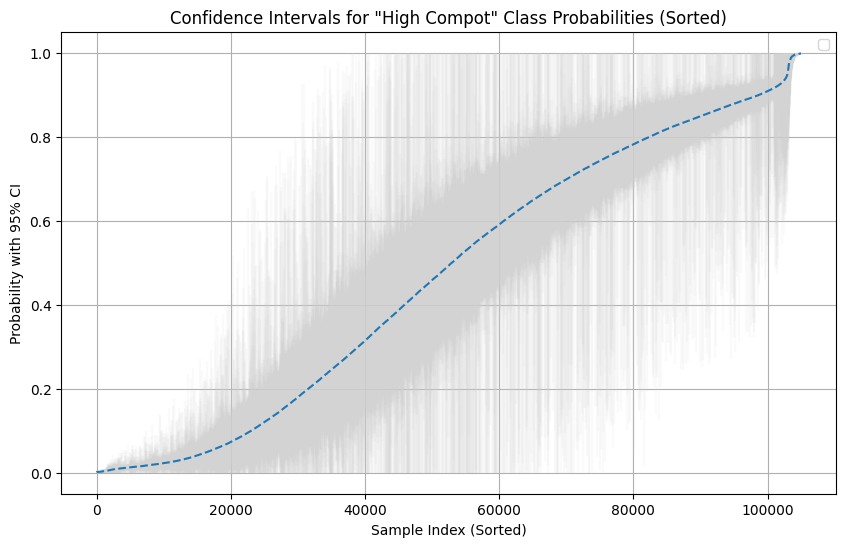

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assuming mc_preds is already defined and contains the relevant columns

# Sort the DataFrame in descending order by 'prob_high_compot'
df_sorted = mc_preds.sort_values(by='prob_high_compot', ascending=True).reset_index(drop=True)

# Extract the sorted columns to numpy arrays for easier handling
sorted_prob_high_compot = df_sorted["prob_high_compot"].to_numpy(dtype=float)
sorted_std_high_compot = df_sorted["std_high_compot"].to_numpy(dtype=float)
indices = np.arange(len(sorted_prob_high_compot))  # Indices after sorting

# Calculate the 95% confidence intervals
z_score = 1.96  # Z-score for 95% confidence
sorted_conf_intervals = z_score * sorted_std_high_compot

# Adjust the confidence intervals for truncation at 0 and 1
lower_bounds = np.maximum(sorted_prob_high_compot - sorted_conf_intervals, 0)
upper_bounds = np.minimum(sorted_prob_high_compot + sorted_conf_intervals, 1)

# Plotting
plt.figure(figsize=(10, 6))

# Plot the error bars with transparency
plt.errorbar(indices, sorted_prob_high_compot, yerr=[sorted_prob_high_compot - lower_bounds, upper_bounds - sorted_prob_high_compot], fmt='none', ecolor='lightgrey', alpha=0.1, capthick=1)

# Plot the mean markers
plt.plot(indices, sorted_prob_high_compot, '--')

plt.title('Confidence Intervals for "High Compot" Class Probabilities (Sorted)')
plt.xlabel('Sample Index (Sorted)')
plt.ylabel('Probability with 95% CI')
plt.legend()
plt.grid(True)
plt.show()

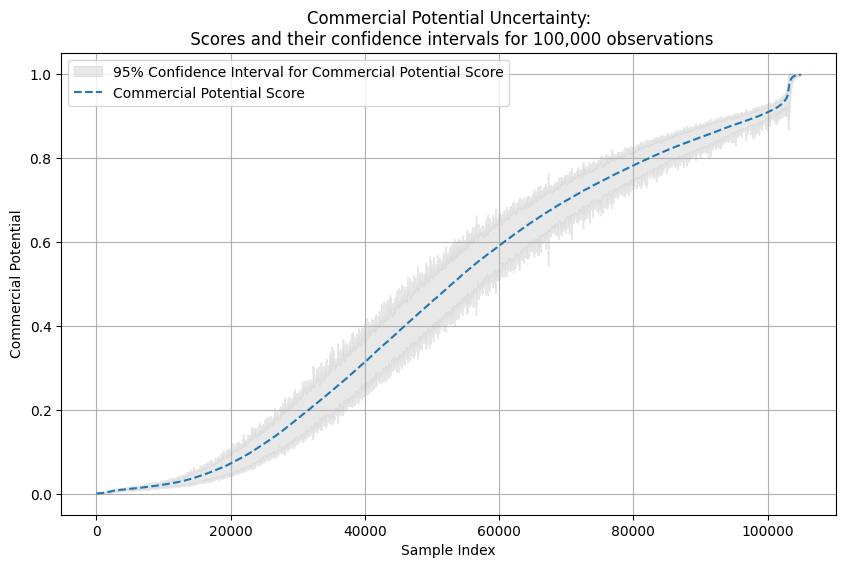

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df_inf_sample is already defined and contains the relevant columns

# Sort the DataFrame in ascending order by 'prob_high_compot'
df_sorted = mc_preds.sort_values(by='prob_high_compot', ascending=True).reset_index(drop=True)

# Extract the sorted columns to numpy arrays for easier handling
sorted_prob_high_compot = df_sorted["prob_high_compot"].to_numpy(dtype=float)
sorted_std_high_compot = df_sorted["std_high_compot"].to_numpy(dtype=float)

# Calculate the 95% confidence intervals
z_score = 1.96  # Z-score for 95% confidence
sorted_conf_intervals = z_score * sorted_std_high_compot

# Adjust the confidence intervals for truncation at 0 and 1
lower_bounds = np.maximum(sorted_prob_high_compot - sorted_conf_intervals, 0)
upper_bounds = np.minimum(sorted_prob_high_compot + sorted_conf_intervals, 1)

# Define a rolling window size (adjust this based on your data)
window_size = 50

# Compute rolling averages
rolling_mean = pd.Series(sorted_prob_high_compot).rolling(window=window_size, center=True).mean()
rolling_lower = pd.Series(lower_bounds).rolling(window=window_size, center=True).mean()
rolling_upper = pd.Series(upper_bounds).rolling(window=window_size, center=True).mean()

# Plotting
plt.figure(figsize=(10, 6))

# Plot the rolling confidence interval as a shaded area
plt.fill_between(range(len(rolling_mean)), rolling_lower, rolling_upper, color='lightgrey', alpha=0.5, label='95% Confidence Interval for Commercial Potential Score')

# Plot the rolling mean line
plt.plot(rolling_mean, '--', label='Commercial Potential Score')

plt.title('Commercial Potential Uncertainty:\n Scores and their confidence intervals for 100,000 observations')
plt.xlabel('Sample Index')
plt.ylabel('Commercial Potential')
plt.legend()
plt.grid(True)
plt.show()

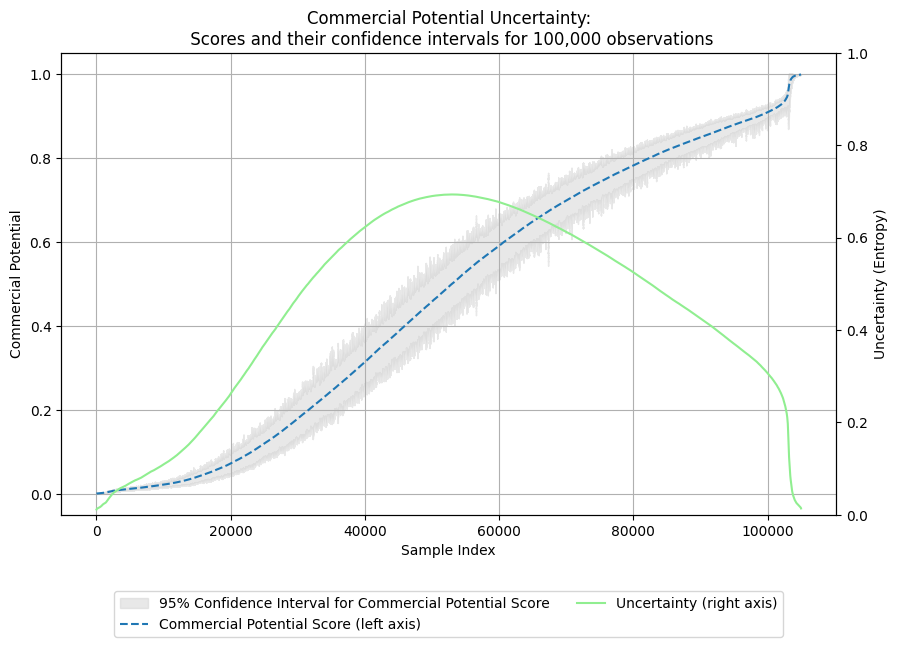

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df_inf_sample is already defined and contains the relevant columns

# Sort the DataFrame in ascending order by 'prob_high_compot'
df_sorted = mc_preds.sort_values(by='prob_high_compot', ascending=True).reset_index(drop=True)

# Extract the sorted columns to numpy arrays for easier handling
sorted_prob_high_compot = df_sorted["prob_high_compot"].to_numpy(dtype=float)
sorted_std_high_compot = df_sorted["std_high_compot"].to_numpy(dtype=float)

# Calculate the 95% confidence intervals
z_score = 1.96  # Z-score for 95% confidence
sorted_conf_intervals = z_score * sorted_std_high_compot

# Adjust the confidence intervals for truncation at 0 and 1
lower_bounds = np.maximum(sorted_prob_high_compot - sorted_conf_intervals, 0)
upper_bounds = np.minimum(sorted_prob_high_compot + sorted_conf_intervals, 1)

# Define a rolling window size (adjust this based on your data)
window_size = 50

# Compute rolling averages
rolling_mean = pd.Series(sorted_prob_high_compot).rolling(window=window_size, center=True).mean()
rolling_lower = pd.Series(lower_bounds).rolling(window=window_size, center=True).mean()
rolling_upper = pd.Series(upper_bounds).rolling(window=window_size, center=True).mean()

# Calculate entropy for each probability
entropy = - (sorted_prob_high_compot * np.log(sorted_prob_high_compot + 1e-9) + 
             (1 - sorted_prob_high_compot) * np.log(1 - sorted_prob_high_compot + 1e-9))

# Compute rolling entropy
rolling_entropy = pd.Series(entropy).rolling(window=window_size, center=True).mean()

# Plotting
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the rolling confidence interval as a shaded area
ax1.fill_between(range(len(rolling_mean)), rolling_lower, rolling_upper, color='lightgrey', alpha=0.5, label='95% Confidence Interval for Commercial Potential Score')

# Plot the rolling mean line
ax1.plot(rolling_mean, '--', label='Commercial Potential Score (left axis)')

# Set the labels and title for the left axis
ax1.set_xlabel('Sample Index')
ax1.set_ylabel('Commercial Potential')
ax1.set_title('Commercial Potential Uncertainty:\n Scores and their confidence intervals for 100,000 observations')

# Create a secondary axis on the right for entropy
ax2 = ax1.twinx()
ax2.plot(rolling_entropy, label='Uncertainty (right axis)', color='lightgreen')
ax2.set_ylabel('Uncertainty (Entropy)')

# Set the scale of ax2 from 0 to 1
ax2.set_ylim(0, 1)

# Combine legends from both axes and place it outside the plot in the lower center
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)

# Add grid and show the plot
ax1.grid(True)

# Save the figure as a PNG file
plt.savefig("compot_uncertainty.png", dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

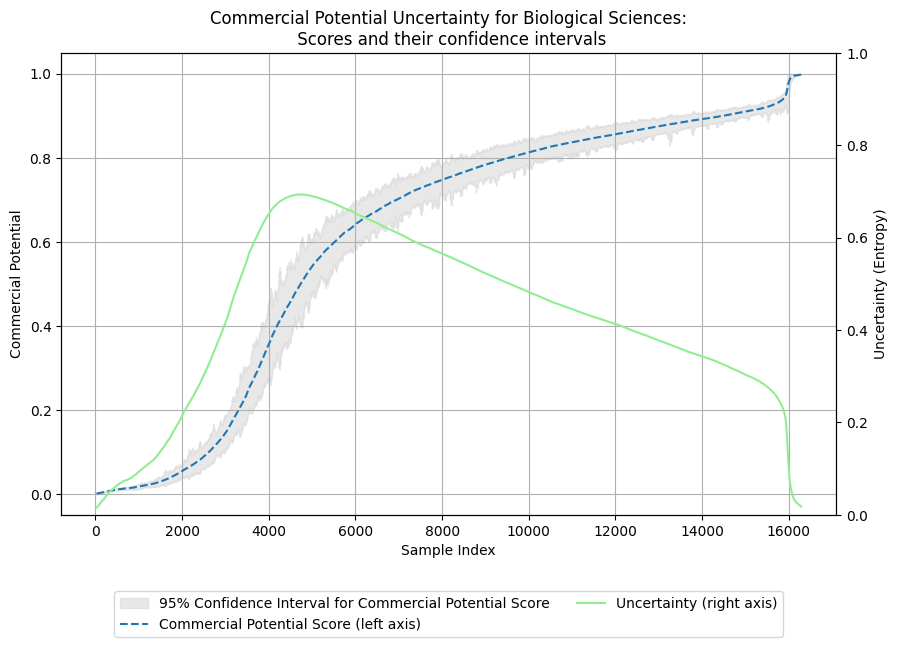

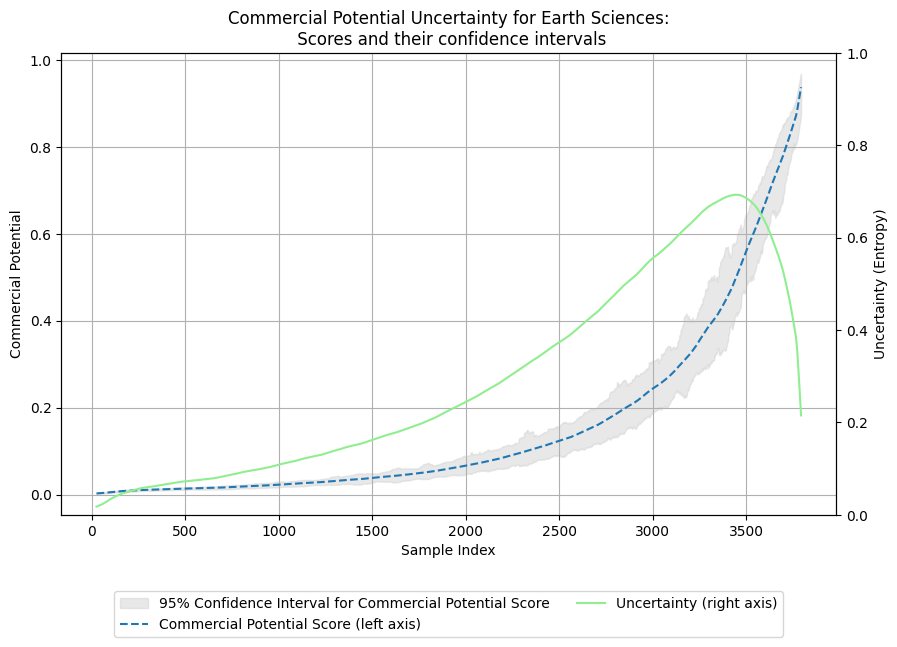

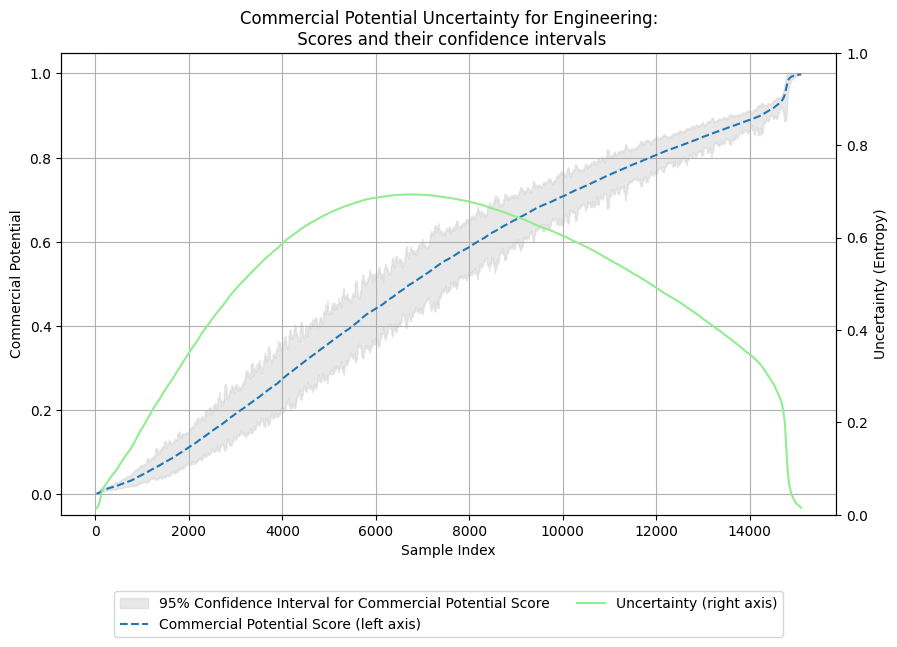

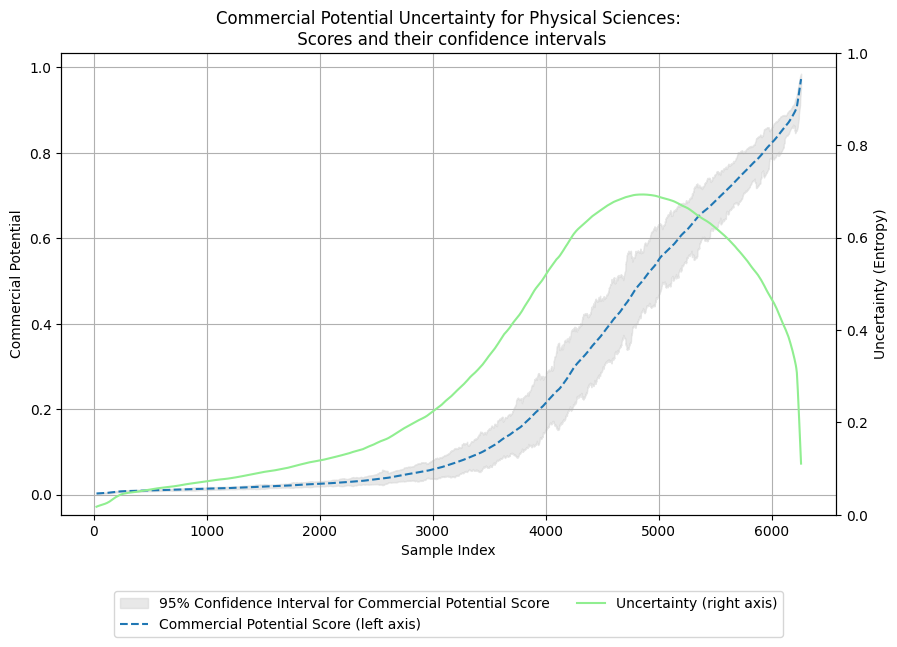

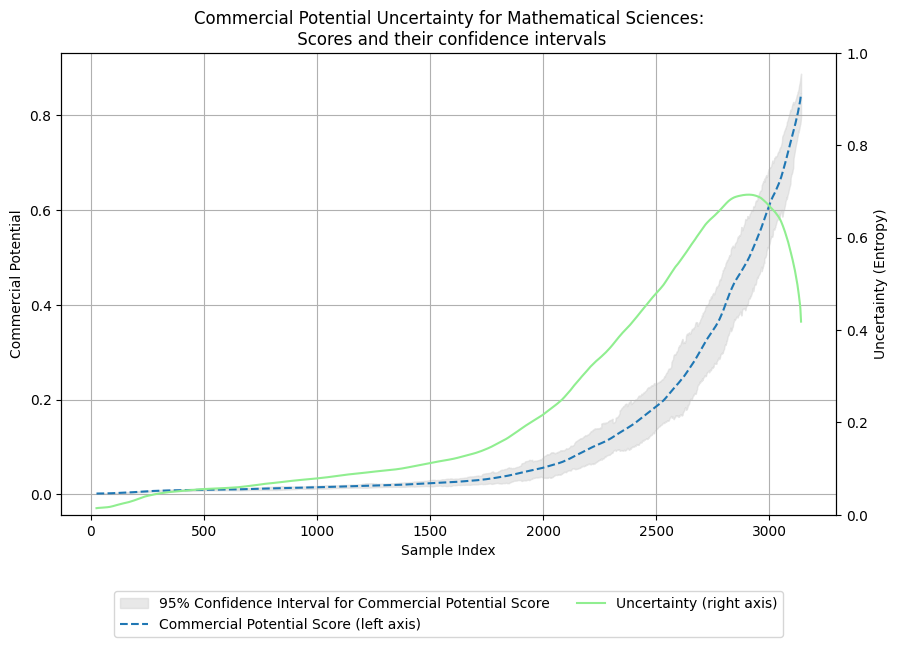

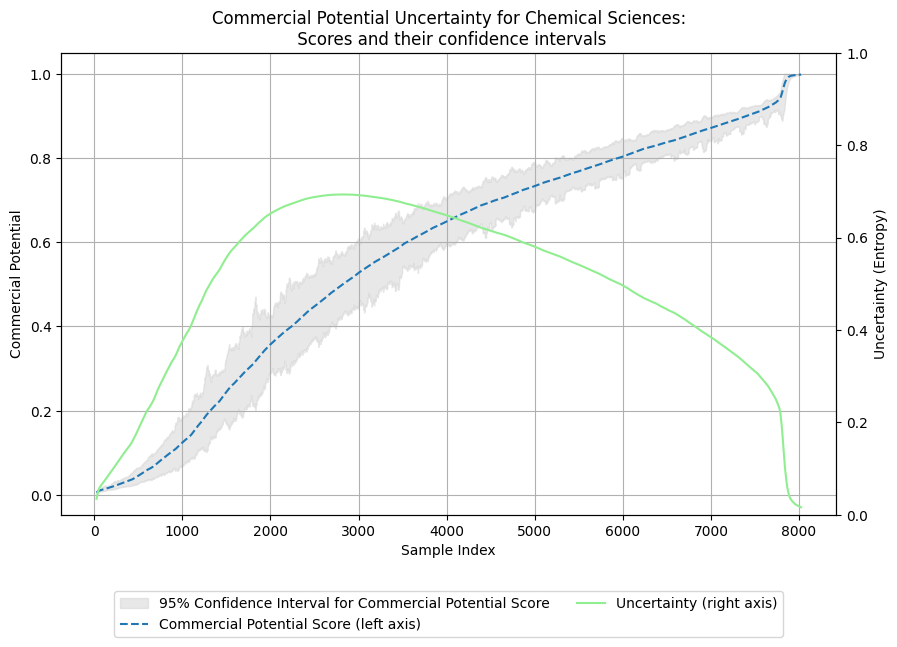

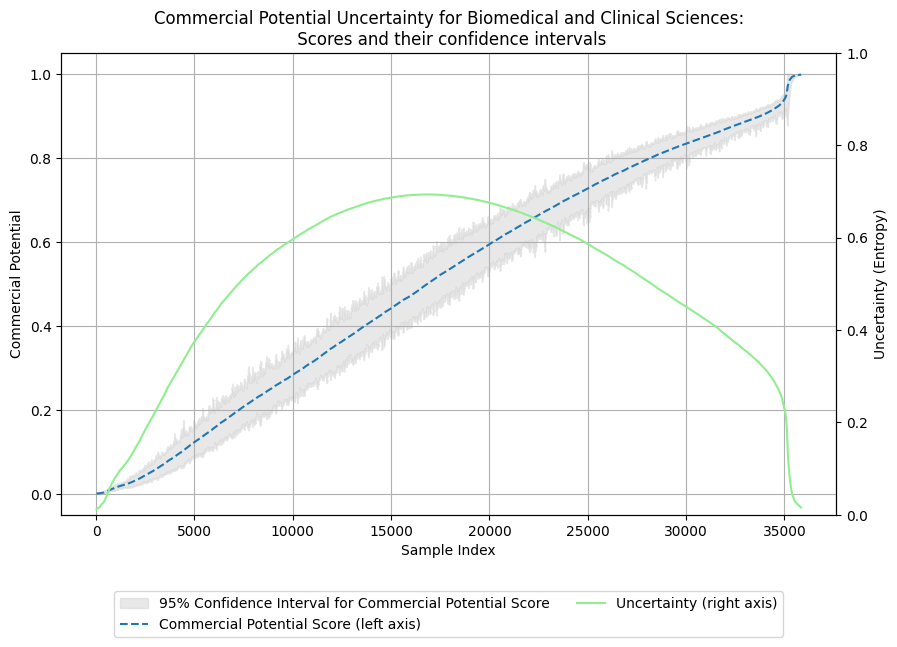

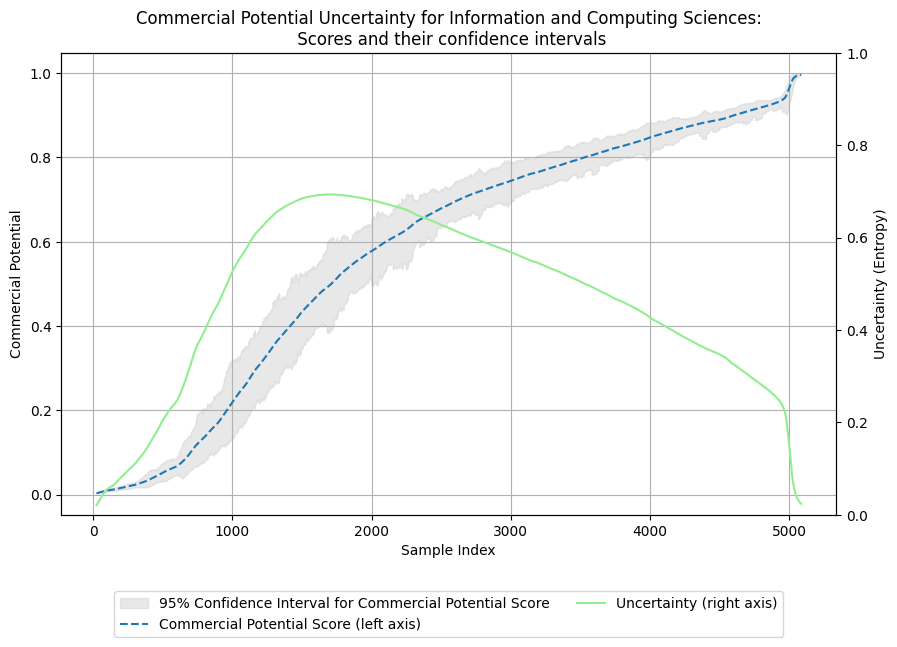

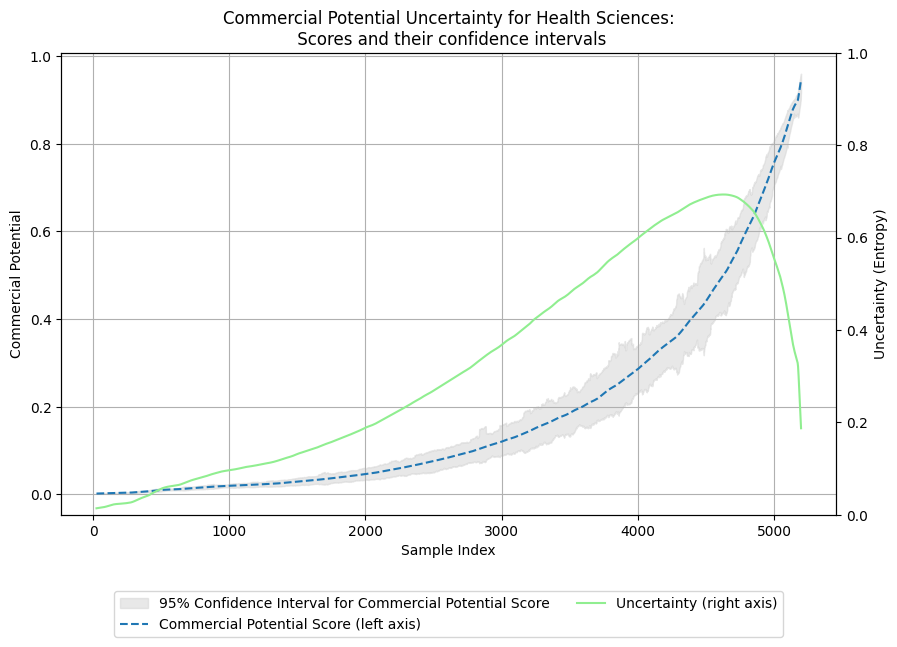

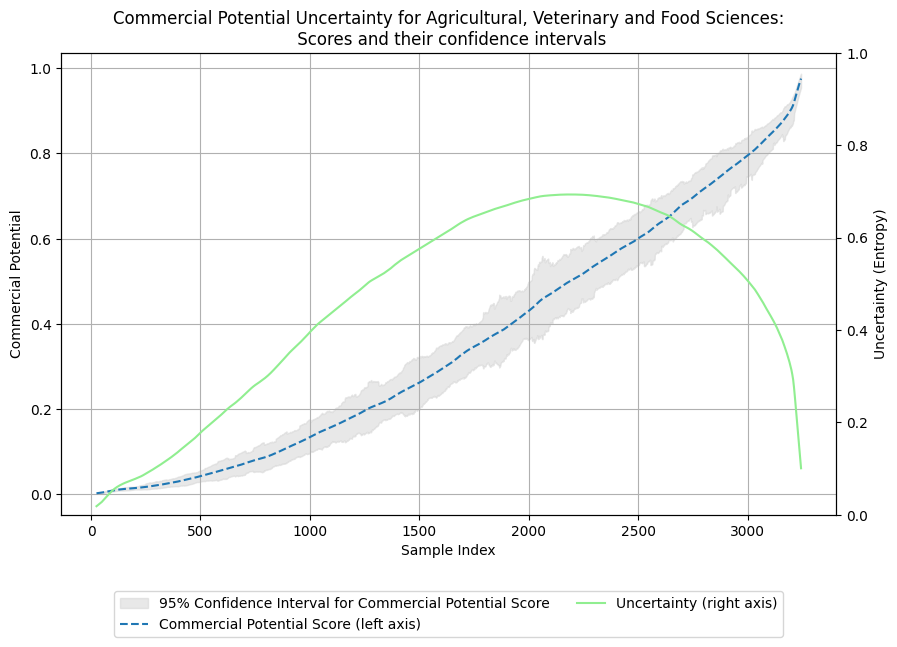

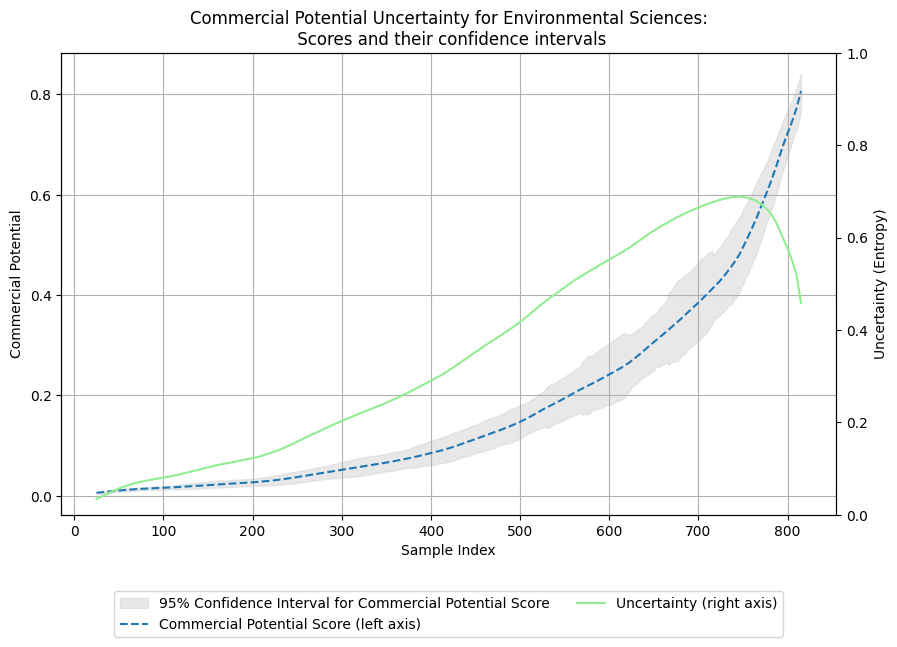

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df_inf_sample is already defined and contains the relevant columns

# Iterate over each unique value in the 'field' column
for field_value in mc_preds['field'].unique():
    # Filter the DataFrame for the current field
    df_field = mc_preds[mc_preds['field'] == field_value]

    # Check if the number of observations for this field is at least 800
    if len(df_field) < 800:
        continue  # Skip this field if it has less than 800 observations

    # Sort the DataFrame in ascending order by 'prob_high_compot'
    df_sorted = df_field.sort_values(by='prob_high_compot', ascending=True).reset_index(drop=True)

    # Extract the sorted columns to numpy arrays for easier handling
    sorted_prob_high_compot = df_sorted["prob_high_compot"].to_numpy(dtype=float)
    sorted_std_high_compot = df_sorted["std_high_compot"].to_numpy(dtype=float)

    # Calculate the 95% confidence intervals
    z_score = 1.96  # Z-score for 95% confidence
    sorted_conf_intervals = z_score * sorted_std_high_compot

    # Adjust the confidence intervals for truncation at 0 and 1
    lower_bounds = np.maximum(sorted_prob_high_compot - sorted_conf_intervals, 0)
    upper_bounds = np.minimum(sorted_prob_high_compot + sorted_conf_intervals, 1)

    # Define a rolling window size (adjust this based on your data)
    window_size = 50

    # Compute rolling averages
    rolling_mean = pd.Series(sorted_prob_high_compot).rolling(window=window_size, center=True).mean()
    rolling_lower = pd.Series(lower_bounds).rolling(window=window_size, center=True).mean()
    rolling_upper = pd.Series(upper_bounds).rolling(window=window_size, center=True).mean()

    # Calculate entropy for each probability
    entropy = - (sorted_prob_high_compot * np.log(sorted_prob_high_compot + 1e-9) + 
                 (1 - sorted_prob_high_compot) * np.log(1 - sorted_prob_high_compot + 1e-9))

    # Compute rolling entropy
    rolling_entropy = pd.Series(entropy).rolling(window=window_size, center=True).mean()

    # Plotting
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot the rolling confidence interval as a shaded area
    ax1.fill_between(range(len(rolling_mean)), rolling_lower, rolling_upper, color='lightgrey', alpha=0.5, label='95% Confidence Interval for Commercial Potential Score')

    # Plot the rolling mean line
    ax1.plot(rolling_mean, '--', label='Commercial Potential Score (left axis)')

    # Set the labels and title for the left axis
    ax1.set_xlabel('Sample Index')
    ax1.set_ylabel('Commercial Potential')
    ax1.set_title(f'Commercial Potential Uncertainty for {field_value}:\n Scores and their confidence intervals')

    # Create a secondary axis on the right for entropy
    ax2 = ax1.twinx()
    ax2.plot(rolling_entropy, label='Uncertainty (right axis)', color='lightgreen')
    ax2.set_ylabel('Uncertainty (Entropy)')

    # Set the scale of ax2 from 0 to 1
    ax2.set_ylim(0, 1)

    # Combine legends from both axes and place it outside the plot in the lower center
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)

    # Add grid and show the plot
    ax1.grid(True)

    # Save the figure as a PNG file, using the field value in the filename
    plt.savefig(f"compot_uncertainty_{field_value}.png", dpi=300, bbox_inches='tight')

    # Show the plot
    plt.show()

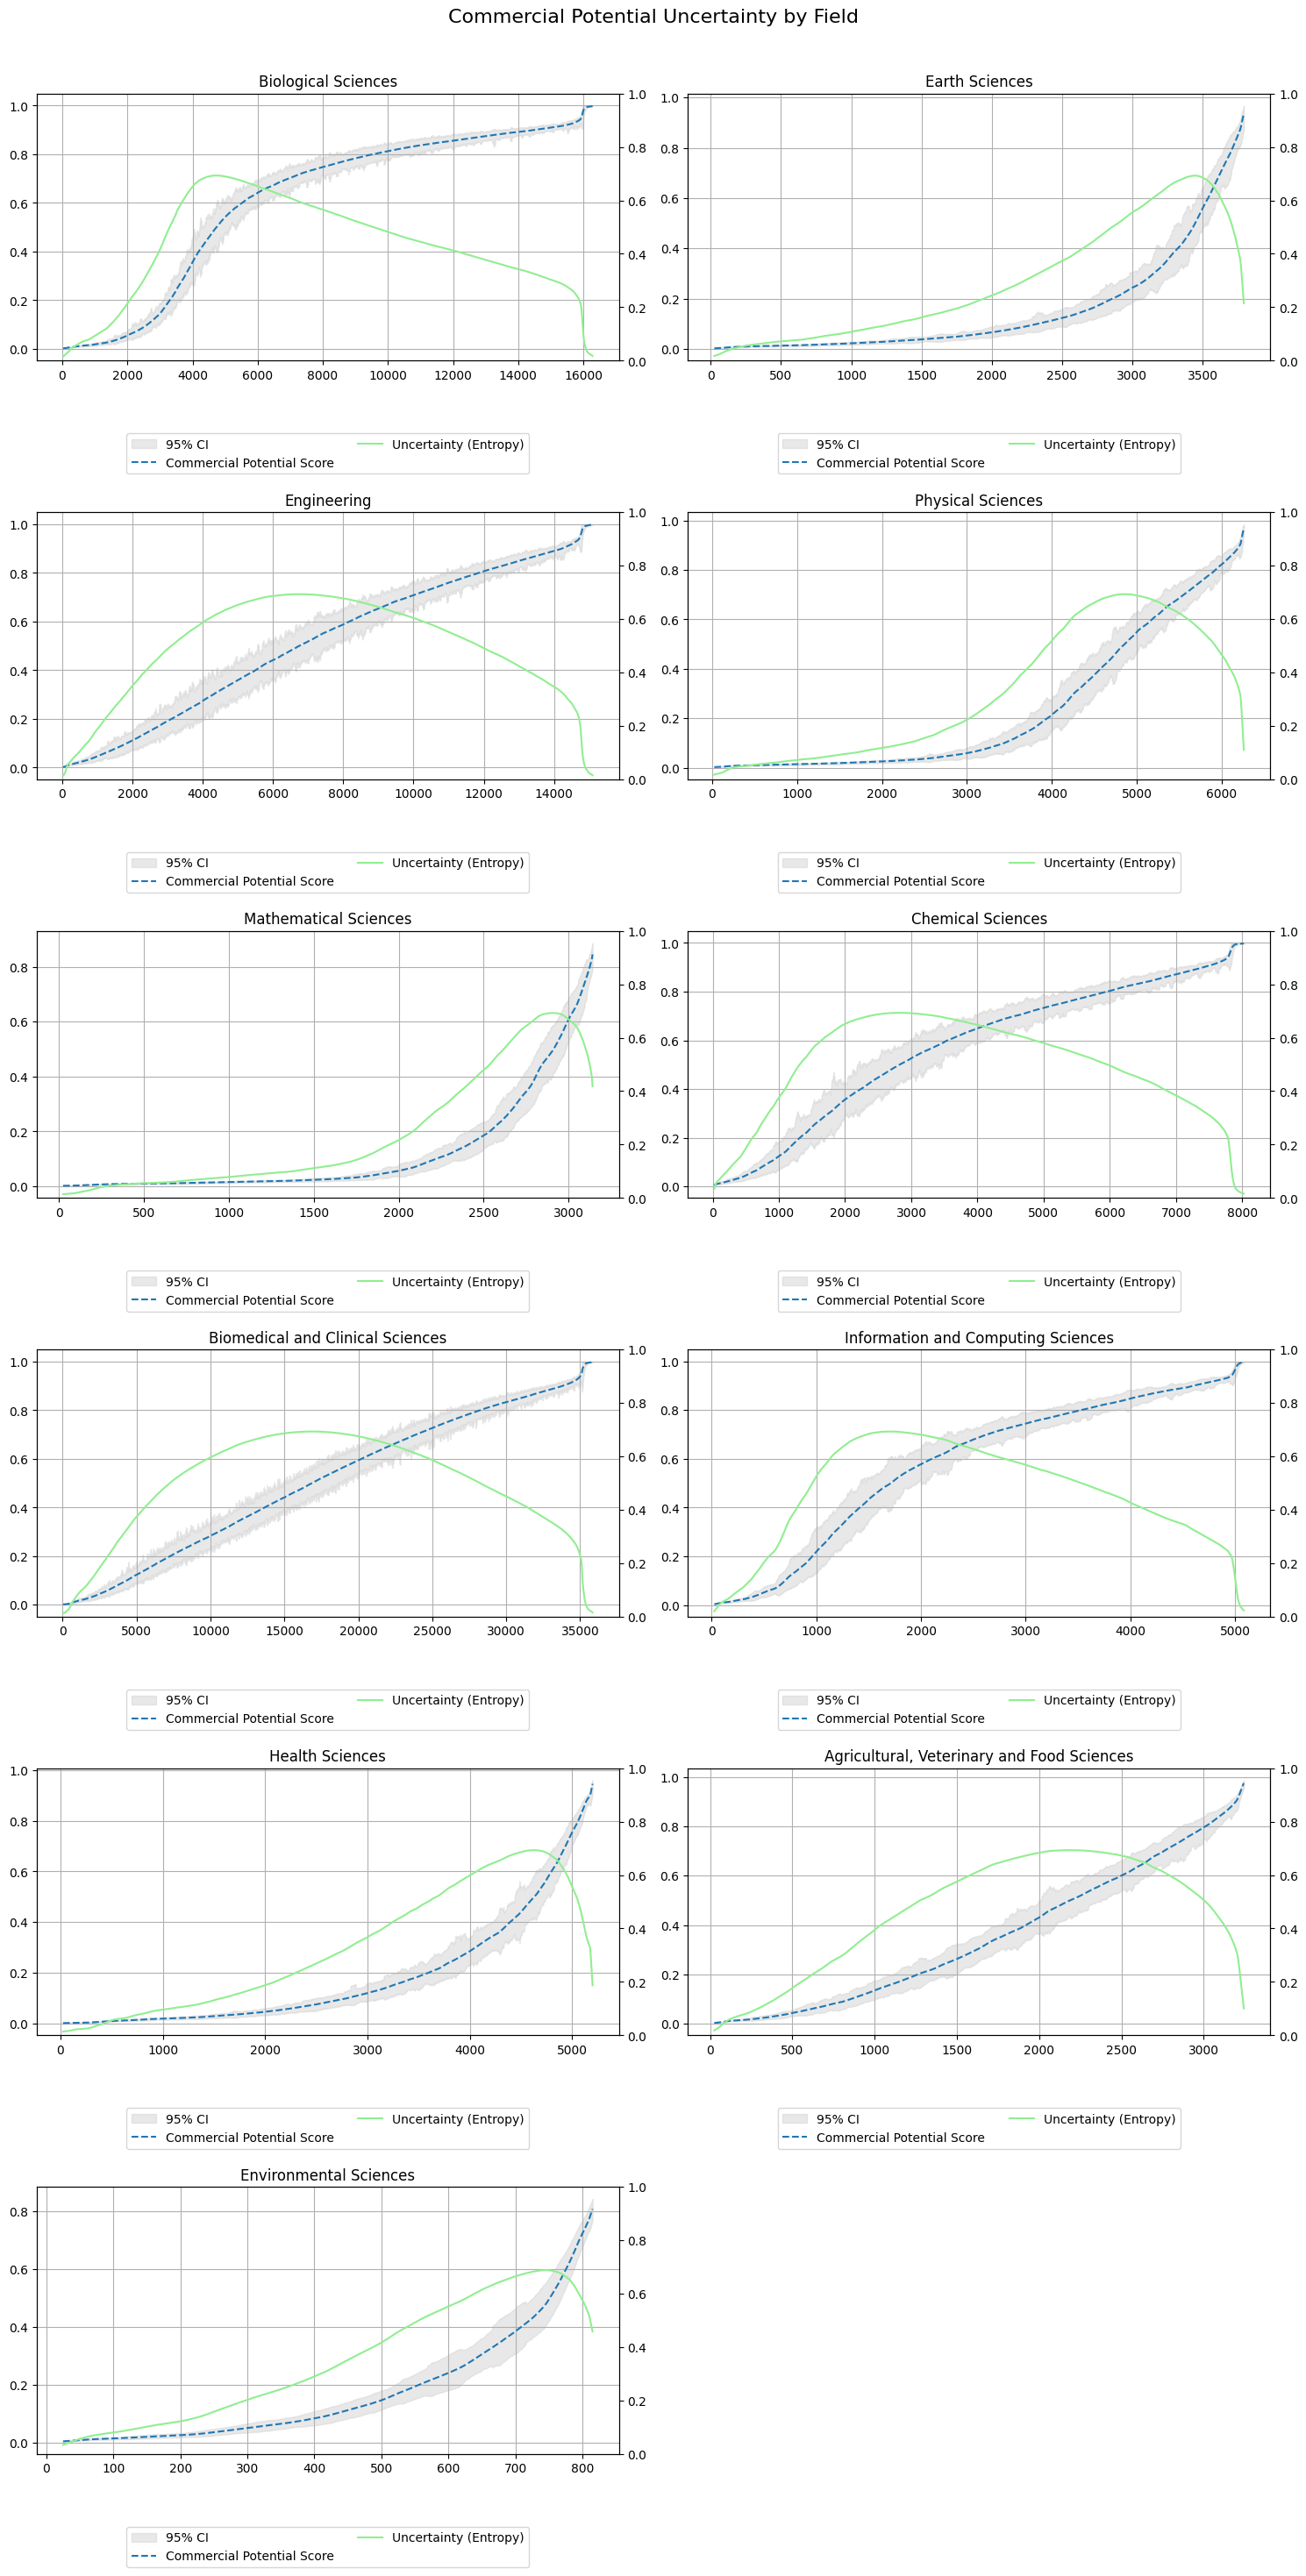

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df_inf_sample is already defined and contains the relevant columns

# Filter fields with at least 800 observations
fields_to_plot = [field_value for field_value in mc_preds['field'].unique() if len(mc_preds[mc_preds['field'] == field_value]) >= 800]

# Determine the number of rows and columns for subplots
n_fields = len(fields_to_plot)
n_cols = 2  # Adjust this based on how many columns you want
n_rows = (n_fields + n_cols - 1) // n_cols  # Ensure all fields are covered

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten()  # Flatten the axes array for easy indexing

# Iterate over each field and its corresponding subplot axis
for i, field_value in enumerate(fields_to_plot):
    ax1 = axes[i]
    
    # Filter the DataFrame for the current field
    df_field = mc_preds[mc_preds['field'] == field_value]

    # Sort the DataFrame in ascending order by 'prob_high_compot'
    df_sorted = df_field.sort_values(by='prob_high_compot', ascending=True).reset_index(drop=True)

    # Extract the sorted columns to numpy arrays for easier handling
    sorted_prob_high_compot = df_sorted["prob_high_compot"].to_numpy(dtype=float)
    sorted_std_high_compot = df_sorted["std_high_compot"].to_numpy(dtype=float)

    # Calculate the 95% confidence intervals
    z_score = 1.96  # Z-score for 95% confidence
    sorted_conf_intervals = z_score * sorted_std_high_compot

    # Adjust the confidence intervals for truncation at 0 and 1
    lower_bounds = np.maximum(sorted_prob_high_compot - sorted_conf_intervals, 0)
    upper_bounds = np.minimum(sorted_prob_high_compot + sorted_conf_intervals, 1)

    # Define a rolling window size (adjust this based on your data)
    window_size = 50

    # Compute rolling averages
    rolling_mean = pd.Series(sorted_prob_high_compot).rolling(window=window_size, center=True).mean()
    rolling_lower = pd.Series(lower_bounds).rolling(window=window_size, center=True).mean()
    rolling_upper = pd.Series(upper_bounds).rolling(window=window_size, center=True).mean()

    # Calculate entropy for each probability
    entropy = - (sorted_prob_high_compot * np.log(sorted_prob_high_compot + 1e-9) + 
                 (1 - sorted_prob_high_compot) * np.log(1 - sorted_prob_high_compot + 1e-9))

    # Compute rolling entropy
    rolling_entropy = pd.Series(entropy).rolling(window=window_size, center=True).mean()

    # Plot the rolling confidence interval as a shaded area
    ax1.fill_between(range(len(rolling_mean)), rolling_lower, rolling_upper, color='lightgrey', alpha=0.5, label='95% CI')

    # Plot the rolling mean line
    ax1.plot(rolling_mean, '--', label='Commercial Potential Score')

    # Create a secondary axis on the right for entropy
    ax2 = ax1.twinx()
    ax2.plot(rolling_entropy, label='Uncertainty (Entropy)', color='lightgreen')

    # Set the scale of ax2 from 0 to 1
    ax2.set_ylim(0, 1)

    # Set the title for each subplot
    ax1.set_title(f'{field_value}')

    # Add legends and grid
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper center', bbox_to_anchor=(0.5, -0.25), ncol=2)
    ax1.grid(True)

# Hide any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout to make sure plots use full width and don't overlap
plt.tight_layout(rect=[0, 0, 1, 0.96])
fig.suptitle('Commercial Potential Uncertainty by Field', fontsize=16)


# Save the figure as a PNG file
plt.savefig("compot_uncertainty_by_field.png", dpi=300, bbox_inches='tight')

plt.show()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  # This is added back by InteractiveShellApp.init_path()
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.



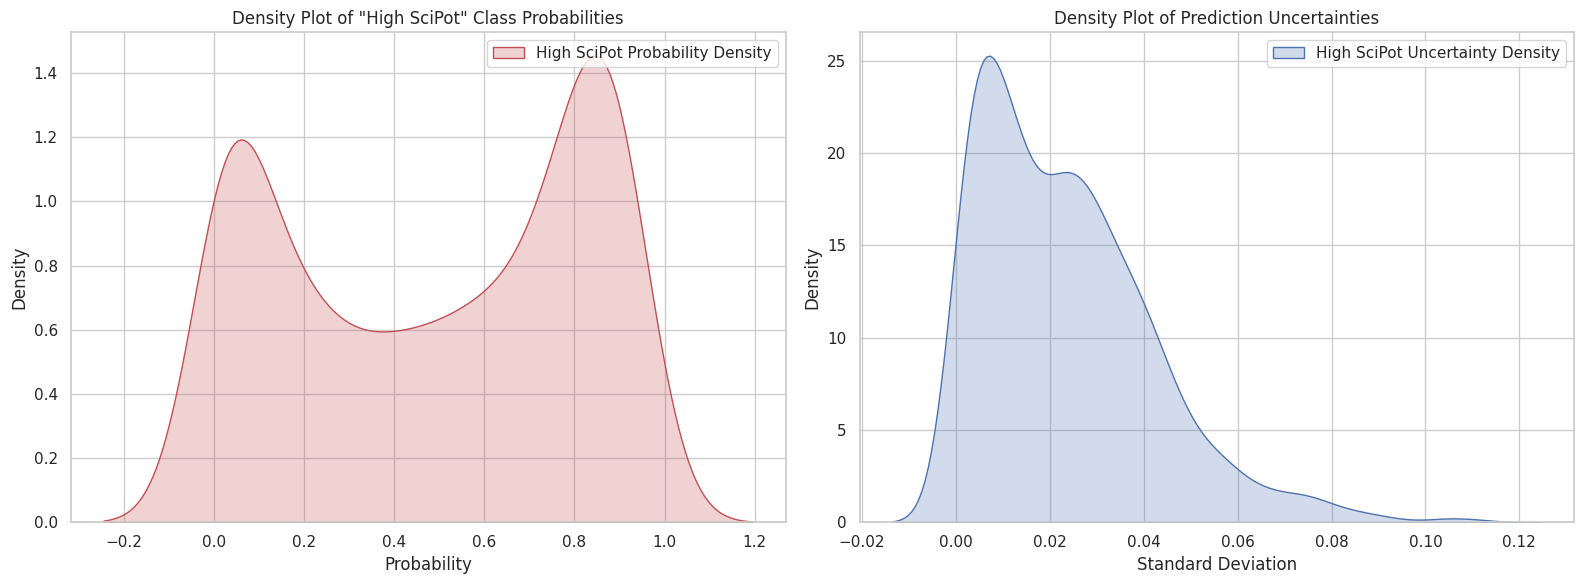

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Setting the style
sns.set(style="whitegrid")

# Creating a figure with two subplots (side by side) for density plots
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Density plot for "high_scipot" probabilities
sns.kdeplot(mc_preds['prob_high_scipot'], shade=True, color="r", label="High SciPot Probability Density", ax=ax[0])
ax[0].set_title('Density Plot of "High SciPot" Class Probabilities')
ax[0].set_xlabel('Probability')
ax[0].set_ylabel('Density')
ax[0].legend()

# Density plot for standard deviations (uncertainties)
sns.kdeplot(mc_preds['std_high_scipot'], shade=True, color="b", label="High SciPot Uncertainty Density", ax=ax[1])
ax[1].set_title('Density Plot of Prediction Uncertainties')
ax[1].set_xlabel('Standard Deviation')
ax[1].set_ylabel('Density')
ax[1].legend()

plt.tight_layout()
plt.show()


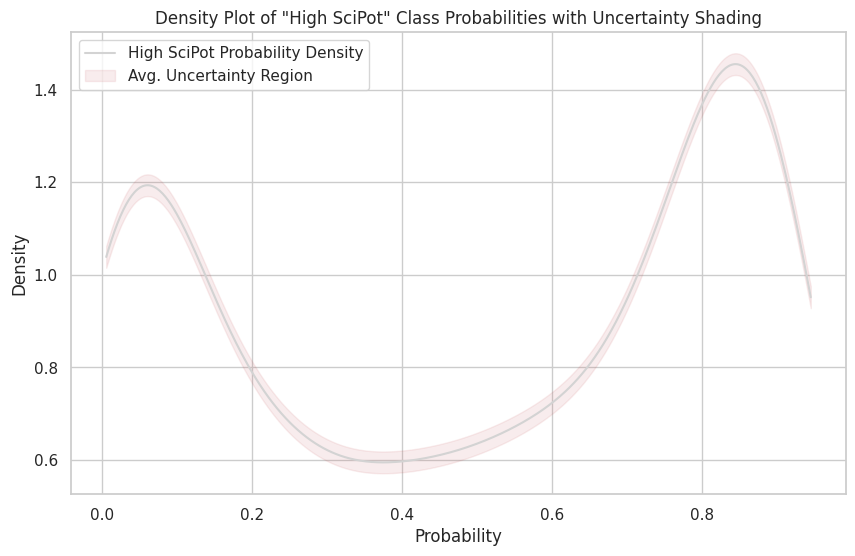

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde

# Assuming 'prob_high_scipot' and 'std_high_scipot' are available in your DataFrame

# Calculate the KDE manually
prob_values = mc_preds['prob_high_scipot'].values
kde = gaussian_kde(prob_values)
x_range = np.linspace(prob_values.min(), prob_values.max(), 500)
kde_values = kde(x_range)

# Calculate the mean standard deviation (uncertainty) as an example
mean_std = mc_preds['std_high_scipot'].mean()

# Plotting the KDE
plt.figure(figsize=(10, 6))
plt.plot(x_range, kde_values, color="lightgrey", label="High SciPot Probability Density")

# Adding a shaded region to represent the average level of uncertainty
plt.fill_between(x_range, kde_values - mean_std, kde_values + mean_std, color='r', alpha=0.1, label='Avg. Uncertainty Region')

plt.title('Density Plot of "High SciPot" Class Probabilities with Uncertainty Shading')
plt.xlabel('Probability')
plt.ylabel('Density')
plt.legend()
plt.show()


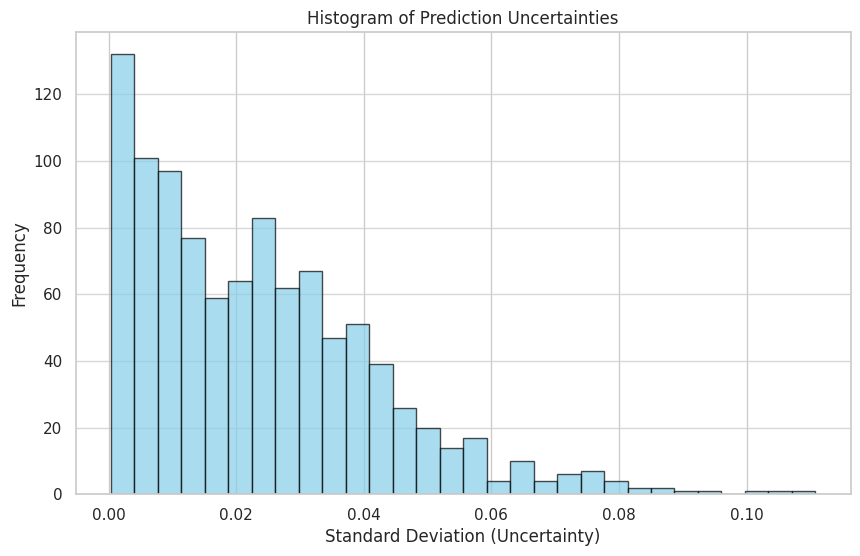

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'std_high_scipot' is the column with standard deviations representing uncertainties

# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.hist(mc_preds['std_high_scipot'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Histogram of Prediction Uncertainties')
plt.xlabel('Standard Deviation (Uncertainty)')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()


current model: v2/v2/scipot_model_2011.bin
Using SciBERT model.


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


model v2/v2/scipot_model_2011.bin successfully loaded
downloading from GBQ v2/v2/scipot_model_2011.bin data...


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


v2/v2/scipot_model_2011.bin data successfully downloaded from GBQ
                pub_id                                           abstract
0       pub.1031590716  Alpha-2-antiplasmin (α2AP) undergoes both N- a...
1       pub.1001402989  It is well established that murine T-lymphocyt...
2       pub.1004817805  The origins and technique of the focused asses...
3       pub.1053785488  Abstract\n                  \n                ...
4       pub.1051240574  BACKGROUND: Inhaled nitric oxide (iNO) is an e...
...                ...                                                ...
101128  pub.1014700009  AIM: The aim of this study was to assess the i...
101129  pub.1010304724  Avian intestinal spirochetosis (AIS) results f...
101130  pub.1022284223  The effectiveness of three new antiarrhythmic ...
101131  pub.1012609984  BACKGROUND: Low vitamin B₁₂ concentrations hav...
101132  pub.1051536263  There has been much recent debate on the relat...

[101133 rows x 2 columns]
Predicting...     S

/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2383: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Counter: 1.0006624939436188
Counter: 2.0003361909564634
Counter: 3.000009887969308
Counter: 4.000672381912927
Counter: 5.000346078925771
Counter: 6.000019775938616
Counter: 7.000682269882234
Counter: 8.000355966895079
Counter: 9.000029663907924
Counter: 10.000692157851542
Counter: 11.000365854864386
Counter: 12.000039551877231
Counter: 13.00070204582085
Counter: 14.000375742833695
Counter: 15.000049439846538
Counter: 16.000711933790157
Counter: 17.000385630803002
Counter: 18.000059327815848
Counter: 19.000721821759466
Counter: 20.00039551877231
Counter: 21.000069215785153
Counter: 22.000731709728772
Counter: 23.000405406741617
Counter: 24.000079103754462
Counter: 25.00074159769808
Counter: 26.000415294710926
Counter: 27.00008899172377
Counter: 28.00075148566739
Counter: 29.00042518268023
Counter: 30.000098879693077
Counter: 31.000761373636696
Counter: 32.00043507064954
Counter: 33.00010876766238
Counter: 34.000771261606005
Counter: 35.00044495861885
Counter: 36.000118655631695
Counter:

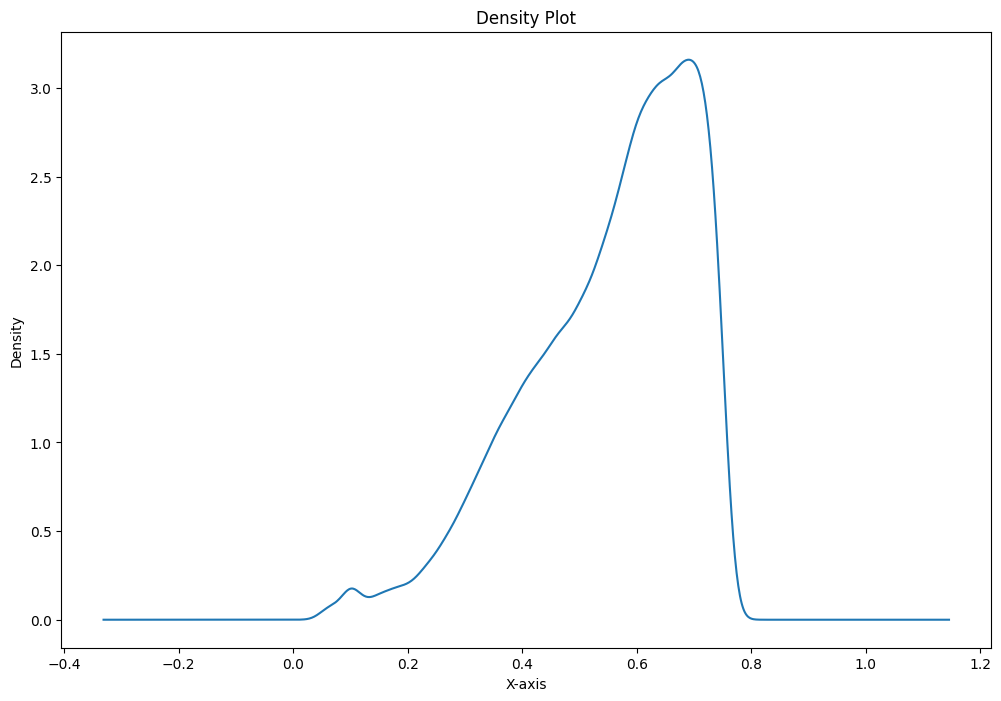

uploading predictions 2011 to GBQ...
predictions 2011 successfully uploaded to GBQ
current model: v2/v2/scipot_model_2012.bin
Using SciBERT model.


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


model v2/v2/scipot_model_2012.bin successfully loaded
downloading from GBQ v2/v2/scipot_model_2012.bin data...


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


v2/v2/scipot_model_2012.bin data successfully downloaded from GBQ
                pub_id                                           abstract
0       pub.1027181018  The light-driven enzyme protochlorophyllide ox...
1       pub.1006363218  This study considers different ways of maximis...
2       pub.1121633502  Abstract\n                  Abstract 60\n     ...
3       pub.1047253998  It is well known that food has a considerable ...
4       pub.1005009360  The complement cascade includes heat-labile pr...
...                ...                                                ...
103345  pub.1060759979  Multivariate transfer entropy (TE) is a model-...
103346  pub.1092819558  The cooling of high temperature gas turbines h...
103347  pub.1005469001  BACKGROUND: Domestic violence has been describ...
103348  pub.1042404096  This paper details the computational design op...
103349  pub.1009884829  Low transpiration rates in pearl millet under ...

[103350 rows x 2 columns]
Predicting...     S

/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2383: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Counter: 1.000483792936623
Counter: 2.0
Counter: 3.000483792936623
Counter: 4.0
Counter: 5.000483792936623
Counter: 6.0
Counter: 7.000483792936623
Counter: 8.0
Counter: 9.000483792936624
Counter: 10.0
Counter: 11.000483792936624
Counter: 12.0
Counter: 13.000483792936624
Counter: 14.0
Counter: 15.000483792936624
Counter: 16.0
Counter: 17.000483792936624
Counter: 18.0
Counter: 19.000483792936624
Counter: 20.0
Counter: 21.000483792936624
Counter: 22.0
Counter: 23.000483792936624
Counter: 24.0
Counter: 25.000483792936624
Counter: 26.0
Counter: 27.000483792936624
Counter: 28.0
Counter: 29.000483792936624
Counter: 30.0
Counter: 31.000483792936624
Counter: 32.0
Counter: 33.00048379293662
Counter: 34.0
Counter: 35.00048379293662
Counter: 36.0
Counter: 37.00048379293662
Counter: 38.0
Counter: 39.00048379293662
Counter: 40.0
Counter: 41.00048379293662
Counter: 42.0
Counter: 43.00048379293662
Counter: 44.0
Counter: 45.00048379293662
Counter: 46.0
Counter: 47.00048379293662
Counter: 48.0
Counter: 

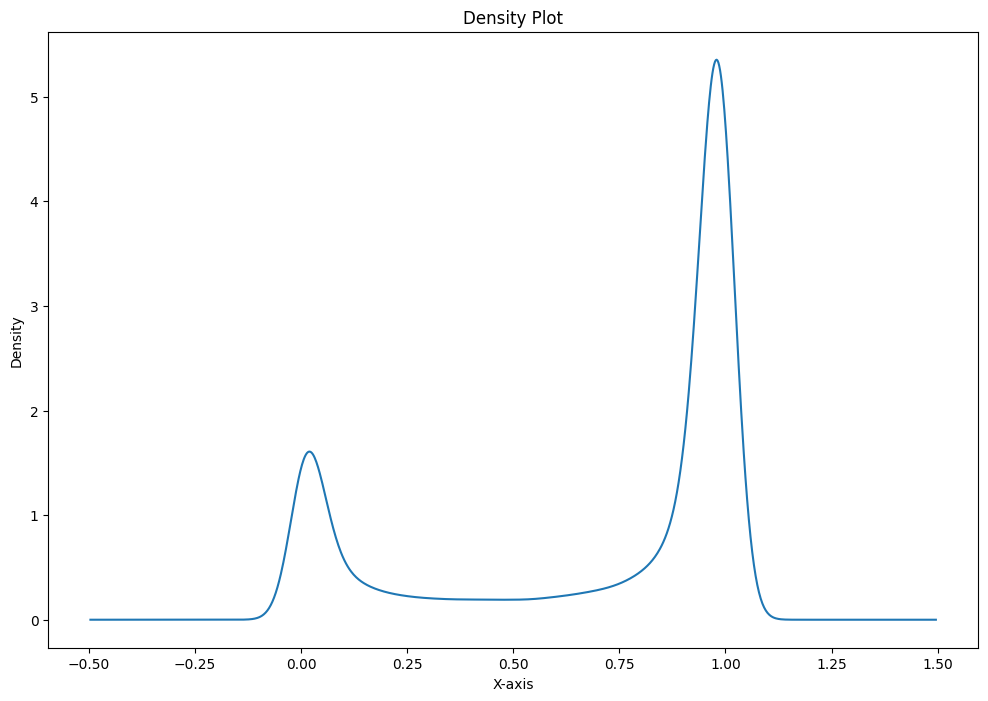

uploading predictions 2012 to GBQ...
predictions 2012 successfully uploaded to GBQ
current model: v2/v2/scipot_model_2013.bin
Using SciBERT model.


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


model v2/v2/scipot_model_2013.bin successfully loaded
downloading from GBQ v2/v2/scipot_model_2013.bin data...


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


v2/v2/scipot_model_2013.bin data successfully downloaded from GBQ
                pub_id                                           abstract
0       pub.1046496890  OBJECTIVE: To investigate 1: plasticity due to...
1       pub.1058084467  This Letter verified eddy current pulse phase ...
2       pub.1006569098  INTRODUCTION: 'Dead ear' is a rare and serious...
3       pub.1017111116  We investigate the excited states of the quasi...
4       pub.1052102104  Conventional approaches to the fabrication of ...
...                ...                                                ...
110495  pub.1023413384  This paper presents a dynamic user equilibrium...
110496  pub.1041981841  Inherited cardiac conditions (ICCs) can lead t...
110497  pub.1032519050  The rhodium-catalyzed methylation of ketones h...
110498  pub.1022302842  BACKGROUND: As international funding for malar...
110499  pub.1037434687  Colletotrichum orbiculare causes anthracnose o...

[110500 rows x 2 columns]
Predicting...     S

/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2383: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Counter: 1.0
Counter: 2.0
Counter: 3.0
Counter: 4.0
Counter: 5.0
Counter: 6.0
Counter: 7.0
Counter: 8.0
Counter: 9.0
Counter: 10.0
Counter: 11.0
Counter: 12.0
Counter: 13.0
Counter: 14.0
Counter: 15.0
Counter: 16.0
Counter: 17.0
Counter: 18.0
Counter: 19.0
Counter: 20.0
Counter: 21.0
Counter: 22.0
Counter: 23.0
Counter: 24.0
Counter: 25.0
Counter: 26.0
Counter: 27.0
Counter: 28.0
Counter: 29.0
Counter: 30.0
Counter: 31.0
Counter: 32.0
Counter: 33.0
Counter: 34.0
Counter: 35.0
Counter: 36.0
Counter: 37.0
Counter: 38.0
Counter: 39.0
Counter: 40.0
Counter: 41.0
Counter: 42.0
Counter: 43.0
Counter: 44.0
Counter: 45.0
Counter: 46.0
Counter: 47.0
Counter: 48.0
Counter: 49.0
Counter: 50.0
Counter: 51.0
Counter: 52.0
Counter: 53.0
Counter: 54.0
Counter: 55.0
Counter: 56.0
Counter: 57.0
Counter: 58.0
Counter: 59.0
Counter: 60.0
Counter: 61.0
Counter: 62.0
Counter: 63.0
Counter: 64.0
Counter: 65.0
Counter: 66.0
Counter: 67.0
Counter: 68.0
Counter: 69.0
Counter: 70.0
Counter: 71.0
Counter: 72.0
C

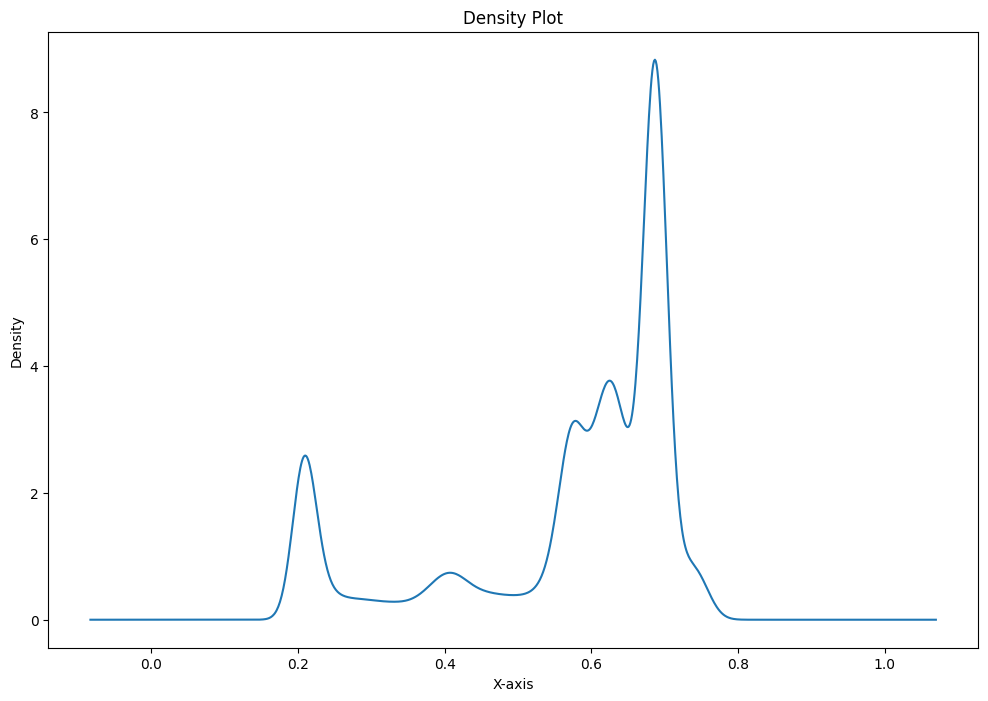

uploading predictions 2013 to GBQ...
predictions 2013 successfully uploaded to GBQ
current model: v2/v2/scipot_model_2014.bin
Using SciBERT model.


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


model v2/v2/scipot_model_2014.bin successfully loaded
downloading from GBQ v2/v2/scipot_model_2014.bin data...


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


v2/v2/scipot_model_2014.bin data successfully downloaded from GBQ
                pub_id                                           abstract
0       pub.1039685662  BACKGROUND: With the need for transparency of ...
1       pub.1046840115  Bullying is a common childhood experience that...
2       pub.1004473025  BACKGROUND: This study aims to characterise th...
3       pub.1034138012  Health systems in Africa which were mainly des...
4       pub.1005414683  A simple method for fabricating Au nano­partic...
...                ...                                                ...
112561  pub.1038702254  This prospective cohort study aimed to examine...
112562  pub.1094943895  Electromagnetic Zenneck THz surface waves prop...
112563  pub.1000411495  Recent advances in Stein’s lemma imply that un...
112564  pub.1003222484  Copper oxide (CuO) nanoparticles (NPs) are amo...
112565  pub.1072142491  Residual stresses in welded joints must be qua...

[112566 rows x 2 columns]
Predicting...     S

/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2383: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Counter: 1.0003020450224758
Counter: 2.0006040900449515
Counter: 3.0000177673542634
Counter: 4.000319812376739
Counter: 5.0006218573992145
Counter: 6.000035534708527
Counter: 7.000337579731002
Counter: 8.000639624753479
Counter: 9.00005330206279
Counter: 10.000355347085266
Counter: 11.00065739210774
Counter: 12.000071069417054
Counter: 13.00037311443953
Counter: 14.000675159462004
Counter: 15.000088836771317
Counter: 16.00039088179379
Counter: 17.000692926816267
Counter: 18.00010660412558
Counter: 19.000408649148056
Counter: 20.000710694170532
Counter: 21.000124371479842
Counter: 22.000426416502318
Counter: 23.000728461524794
Counter: 24.000142138834107
Counter: 25.000444183856583
Counter: 26.00074622887906
Counter: 27.00015990618837
Counter: 28.000461951210845
Counter: 29.00076399623332
Counter: 30.000177673542634
Counter: 31.00047971856511
Counter: 32.00078176358758
Counter: 33.000195440896896
Counter: 34.000497485919375
Counter: 35.00079953094185
Counter: 36.00021320825116
Counter: 

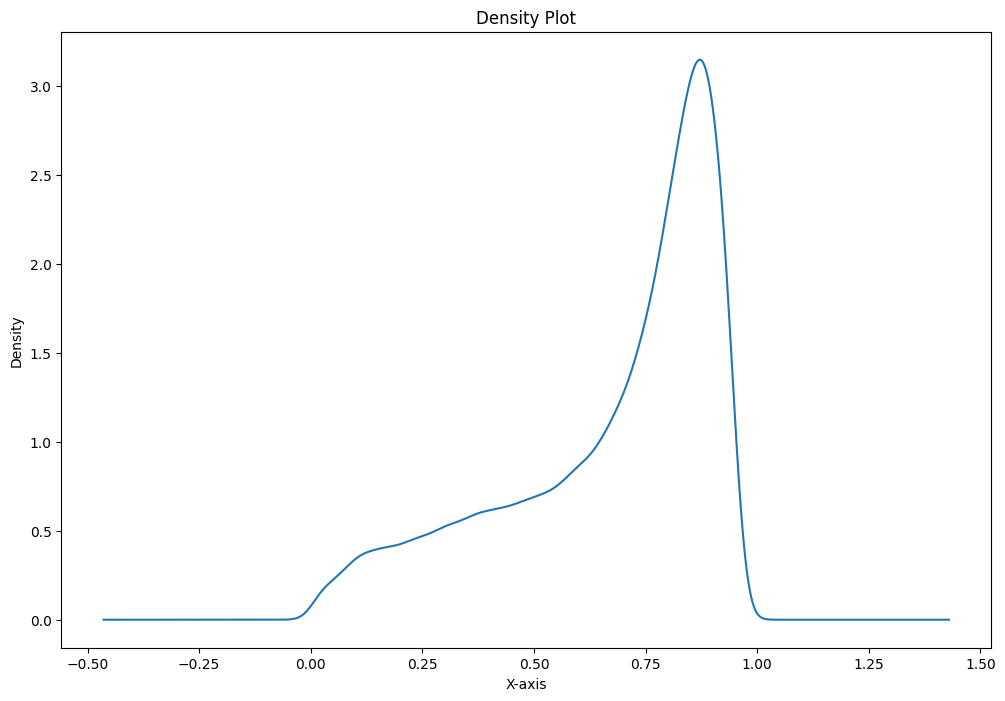

uploading predictions 2014 to GBQ...
predictions 2014 successfully uploaded to GBQ
current model: v2/v2/scipot_model_2015.bin
Using SciBERT model.


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


model v2/v2/scipot_model_2015.bin successfully loaded
downloading from GBQ v2/v2/scipot_model_2015.bin data...


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


v2/v2/scipot_model_2015.bin data successfully downloaded from GBQ
                pub_id                                           abstract
0       pub.1019905902  BACKGROUND: A powered knee-ankle-foot orthosis...
1       pub.1000408217  Mitral annular plane systolic excursion (MAPSE...
2       pub.1017080332  BACKGROUND: Cannabis has a long history of med...
3       pub.1005248605  We report the growth of carbon nanotubes on te...
4       pub.1045969095  OBJECTIVE: To describe the longer-term clinica...
...                ...                                                ...
118825  pub.1049736985  There has been much interest in group judgment...
118826  pub.1095390313  The ability to control the propagation of spin...
118827  pub.1003863431  BACKGROUND: Each year more than 5000 children ...
118828  pub.1053022777  Abstract Dipolarization fronts (DFs) are often...
118829  pub.1007275082  Key PointsDescribes new data on the value of a...

[118830 rows x 2 columns]
Predicting...     S

/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2383: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Counter: 1.0005890768324497
Counter: 2.0003366153328286
Counter: 3.0000841538332073
Counter: 4.000673230665657
Counter: 5.000420769166036
Counter: 6.0001683076664145
Counter: 7.000757384498864
Counter: 8.000504922999243
Counter: 9.00025246149962
Counter: 10.0
Counter: 11.00058907683245
Counter: 12.000336615332829
Counter: 13.000084153833207
Counter: 14.000673230665656


In [ ]:


########################################################################################################################################################################################################################################################################
# CLEAN PREDS DF AND STORE LOCAL CSV
########################################################################################################################################################################################################################################################################

mc_preds = mc_preds.drop(columns=['abstract_inferred'])
print(mc_preds)

# Plot the density using the plot.kde() function
mc_preds['prob_high_scipot'].plot.kde()
# Add labels and a title
plt.xlabel('X-axis')
plt.ylabel('Density')
plt.title('Density Plot')
# Display the plot
plt.show()



########################################################################################################################################################################################################################################################################
# UPLOAD PREDS TO GBQ
########################################################################################################################################################################################################################################################################

# Upload preds to GBQ
print(f'uploading predictions {prediction_year} to GBQ...')

# Set GCP project and BigQuery table details
project_id = 'comsci-353300'
dataset_id = 'derived_preds'
table_id = f'uk_scipot_preds_{prediction_year}'

# Authenticate with Google Cloud using your service account key
client = bigquery.Client(project=project_id)

# Specify the BigQuery table reference
table_ref = client.dataset(dataset_id).table(table_id)

# Upload the Pandas DataFrame to BigQuery with auto-detection
job_config = bigquery.LoadJobConfig(
autodetect=True,  # Enable auto-detection of the schema
write_disposition=bigquery.WriteDisposition.WRITE_TRUNCATE  # You can choose your write disposition
)

# Upload the DataFrame to BigQuery
job = client.load_table_from_dataframe(mc_preds.drop(columns=['abstract']), table_ref, job_config=job_config)
job.result()  # Wait for the job to complete
print(f'predictions {prediction_year} successfully uploaded to GBQ')
